# ICME rate web plots

Adapted from the code for the paper https://iopscience.iop.org/article/10.3847/1538-4357/abb9a1

https://github.com/helioforecast/Papers/tree/master/Moestl2020_PSP_rate

makes a prediction of the ICME rate in solar cycle 25, and solar cycle tracking plots, for the webpage
https://helioforecast.space/solarcycle

Main author: C. Möstl, Austrian Space Weather Office, GeoSphere Austria

part of https://github.com/cmoestl/heliocats

uses environment 'envs/env_helio4.yml'


---

**MIT LICENSE**

Copyright 2020-2023, Christian Moestl

Permission is hereby granted, free of charge, to any person obtaining a copy of this 
software and associated documentation files (the "Software"), to deal in the Software
without restriction, including without limitation the rights to use, copy, modify, 
merge, publish, distribute, sublicense, and/or sell copies of the Software, and to 
permit persons to whom the Software is furnished to do so, subject to the following 
conditions:

The above copyright notice and this permission notice shall be included in all copies 
or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A
PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF 
CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE 
OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [30]:
from scipy import stats
import scipy.io
from matplotlib import cm
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime
from datetime import timedelta
import astropy.constants as const
from sunpy.time import parse_time
import sunpy.time
import time
import pickle
import seaborn as sns
import os
import sys
import urllib
import json
import warnings
import copy
import importlib
import heliopy.spice as spice
import heliopy.data.spice as spicedata
import astropy

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


from heliocats import stats as hs
from heliocats import data as hd
from heliocats import cats as hc

#########################
#Convert this notebook to a script with:
os.system('jupyter nbconvert --to script icme_rate_web.ipynb')    

##### check for system type
#server
if sys.platform == 'linux': 
    print('system is linux')
    matplotlib.use('Agg') 
#mac
if sys.platform =='darwin':  
    print('system is mac')
    %matplotlib inline     


#warnings.filterwarnings('ignore') # some numpy mean-of-empty-slice runtime warnings

########### make directories first time
resdir='results'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

resdir='results/icme_rate'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

#where the in situ data files are located is set as data_path
data_path=datadir+'/icme_rate_data_files/'
if os.path.isdir(data_path) == False: os.mkdir(data_path)

#set output directory
outputdirectory=resdir
    
    
t0all = time.time()    

print('results path', resdir)
print('path for data files', data_path)

[NbConvertApp] Converting notebook icme_rate_web.ipynb to script


system is mac
results path results/icme_rate
path for data files data/icme_rate_data_files/


[NbConvertApp] Writing 89347 bytes to icme_rate_web.py


## 1 Settings and load data

In [2]:
t0 = time.time()
print('----------------------- ')

print('icme_rate main program.')

#constants: 
#solar radius
Rs_in_AU=float(const.R_sun/const.au)
#define AU in km
AU_in_km=const.au.value/1e3

#set for loading
load_data=1
get_new_sunspots=1
get_new_sunspots_ms=1
get_new_sunspots_mean=1
get_new_omni=0


if load_data > 0:
    
    print('load data')
    print('')
    
    #####################
    print('get RC ICME list')    
    #download richardson and cane list
    rc_url='http://www.srl.caltech.edu/ACE/ASC/DATA/level3/icmetable2.htm'

    try: urllib.request.urlretrieve(rc_url,data_path+'rc_list.htm')
    except urllib.error.URLError as e:
        print('Failed downloading ', rc_url,' ',e)

    #read RC list into pandas dataframe    
    rc_dfull=pd.read_html(data_path+'rc_list.htm')
    rc_df=rc_dfull[0]
  

    ##################
    print('get sunspot number from SIDC')    
    #get daily sunspot number from SIDC
    #http://www.sidc.be/silso/datafiles
    #parameters
    #http://www.sidc.be/silso/infosndtot
    #daily sunspot number

    if get_new_sunspots==1:
        ssn=pd.read_csv('http://www.sidc.be/silso/DATA/SN_d_tot_V2.0.csv',sep=';',names=['year','month','day','year2','spot','stand','obs','prov'])     
        
        ssn_time=np.zeros(len(ssn))
        for k in np.arange(len(ssn)):
            ssn_time[k]=mdates.date2num(datetime.datetime(ssn.year[k],ssn.month[k], ssn.day[k]))
        print('time convert done')
        
        ssn.insert(0,'time',ssn_time)    
        #set all standard deviations < 0 to nan
        snan=np.where(ssn.stand< 0)[0]
        for k in snan: ssn.at[k,'stand']=np.nan  
        fileout='ssn.p'
        pickle.dump(ssn, open(data_path+fileout, "wb"))
        

        #also get preliminary data for current month for plotting    
        
        #download 
        ssn_prelim_url='http://www.sidc.be/silso/DATA/EISN/EISN_current.csv'
        try: urllib.request.urlretrieve(ssn_prelim_url,data_path+'EISN_current.csv')
        except urllib.error.URLError as e:
            print('Failed downloading ', ssn_prelim_url,' ',e)
        
        ssn_prelim_raw = np.loadtxt(data_path+'EISN_current.csv', delimiter=',',usecols=(0,1,2,4,5))
        ssn_p_int=ssn_prelim_raw.astype(int)
        ssn_p=pd.DataFrame(ssn_p_int,columns=['year','month','day','spot','stand'])        
        
        ssn_p_time=np.zeros(len(ssn_p))
        for k in np.arange(len(ssn_p)):
            ssn_p_time[k]=mdates.date2num(datetime.datetime(ssn_p.year[k],ssn_p.month[k], ssn_p.day[k]))            
            
        
        ssn_p.insert(0,'time',ssn_p_time)      

        fileout='ssn_prelim.p'
        pickle.dump(ssn_p, open(data_path+fileout, "wb"))
        



    if get_new_sunspots_ms==1:

        #ssn_ms=pd.read_csv('data/SN_ms_tot_V2.0.csv',sep=';')
        ssn_ms=pd.read_csv('http://www.sidc.be/silso/DATA/SN_ms_tot_V2.0.csv',sep=';',names=['year','month','year2','spot','stand','obs','check'])       

        ssn_ms_time=np.zeros(len(ssn_ms))
        for k in np.arange(len(ssn_ms)):
            ssn_ms_time[k]=mdates.date2num(datetime.datetime(ssn_ms.year[k],ssn_ms.month[k], 1))            
        
        ssn_ms.insert(0,'time',ssn_ms_time)
    
        fileout='ssn_13ms.p'
        pickle.dump(ssn_ms, open(data_path+fileout, "wb"))
        
    
    if get_new_sunspots_mean==1:

       
        ssn_m=pd.read_csv('http://www.sidc.be/silso/DATA/SN_m_tot_V2.0.csv',sep=';',names=['year','month','year2','spot','stand','obs','check'])       

        ssn_m_time=np.zeros(len(ssn_m))

        for k in np.arange(len(ssn_m)):
            ssn_m_time[k]=mdates.date2num(datetime.datetime(ssn_m.year[k],ssn_m.month[k], 1))     


        ssn_m.insert(0,'time',ssn_m_time)
    
        fileout='ssn_m.p'
        pickle.dump(ssn_m, open(data_path+fileout, "wb"))

        

    file='ssn.p'  
    ssn=pickle.load(open(data_path+file, "rb"))
    
    file='ssn_13ms.p'  
    ssn_ms=pickle.load(open(data_path+file, "rb"))

    file='ssn_m.p'  
    ssn_m=pickle.load(open(data_path+file, "rb"))

    
    
    #make 13 month running mean
    runmean_months=13.0
    ssn_mean_13=hs.running_mean(ssn.spot,int(np.rint(30.42*runmean_months+1)))
    ssn_std_13=hs.running_mean(ssn.stand,int(np.rint(30.42*runmean_months+1)))    

    ssn.insert(1,'spot_mean_13',ssn_mean_13)    
    ssn.insert(2,'spot_std_13',ssn_std_13)    
    
    print('SIDC sunspots done')

 



    ##----------------------------- spacecraft

    #fileomni="omni_1963_now.p"
    #if get_new_omni==1: hd.save_omni_data(data_path,fileomni)
    #[omni,homni]=pickle.load(open(data_path+fileomni, "rb" ) ) 
    
    
    
    #print('load Ulysses RTN') #made with heliocats.data.save_ulysses_data
    #fileuly='ulysses_1990_2009_rtn.p'
    #[uly,huly]=pickle.load(open(data_path+fileuly, "rb" ) )     
 
    #print('load VEX data (Venus magnetosphere removed) SCEQ') #legacy from HELCATS project in SCEQ, removed magnetosphere
    #filevex='vex_2007_2014_sceq_removed.p'
    #[vex,hvex]=pickle.load(open(data_path+filevex, 'rb' ) )

    #print('load MESSENGER data (Mercury magnetosphere removed) SCEQ') #legacy from HELCATS project in SCEQ, removed magnetosphere
    #filemes='messenger_2007_2015_sceq_removed.p'
    #[mes,hmes]=pickle.load(open(data_path+filemes, 'rb' ) )
 
    print('load STEREO-B data RTN') #yearly magplasma files from stereo science center, conversion to SCEQ 
    filestb='stereob_2007_2014_rtn.p'
    [stb,hstb]=pickle.load(open(data_path+filestb, "rb" ) )      
    
    

    ########### CURRENT ACTIVE SPACECRAFT    


    ############### convert MAVEN from Cyril's MAT file to pickle
    
    #from heliocats import data as hd
    #importlib.reload(hd) #reload again while debugging
    
    #file_input=data_path+'input/Data-MAVEN-MAG_SolarWind_102014-012021.mat'        
    #filename=data_path+'maven_2014_2021_removed_no_plasma.p'
    #hd.convert_MAVEN_mat_removed(file_input,filename)

    #filemav=data_path+'maven_2014_2021_removed_no_plasma.p'   
    #filename=data_path+'maven_2014_2021_removed_smoothed_no_plasma.p'   
    #hd.MAVEN_smooth_orbit(filemav,filename)
    
    
    #print('load MAVEN data MSO') 
    #filemav='maven_2014_2018.p'
    #[mav,hmav]=pickle.load(open(filemav, 'rb' ) )

    #combined plasma and mag
    #filemav='maven_2014_2018_removed.p'
    #[mavr,hmavr]=pickle.load(open(data_path+filemav, 'rb' ) )    
    #filemav='maven_2014_2018_removed_smoothed.p'
    #[mav,hmav]=pickle.load(open(data_path+filemav, 'rb' ) )

    #only mag
    #filemav='maven_2014_2021_removed_no_plasma.p'
    #[mav2,hmav2]=pickle.load(open(data_path+filemav, 'rb' ) )    

    #filemav='maven_2014_2021_removed_smoothed_no_plasma.p'
    #[mavr2,hmavr2]=pickle.load(open(data_path+filemav, 'rb' ) )    


    
    #removed magnetosphere by C. Simon Wedlund, 1 data point per orbit, MSO
    #filemav='maven_2014_2021_removed_smoothed.p'
    #[mav,hmav]=pickle.load(open(data_path+filemav, 'rb' ) )
    
        
    #use hd.save_msl_rad() first to convert data doseE_sol_filter_2019.dat to pickle file
    #print('load MSL RAD')
    #MSL RAD
    #rad=hd.load_msl_rad(data_path)#, rad.time,rad.dose_sol
    
     ################################ Bepi Colombo
    #print('load Bepi Colombo RTN')
    #filebepi='bepi_ib_2019_now_rtn.p'
    #[bepi,bepiheader]=pickle.load(open(data_path+filebepi, "rb" ) )  
  
   
    ########### STA
    
    print('load and merge STEREO-A data') #yearly magplasma files from stereo science center, conversion to SCEQ 
    filesta1='stereoa_2007_now_rtn.p'
    [sta1,hsta1]=pickle.load(open(data_path+filesta1, "rb" ) )  
    
    #beacon data
    filesta2='stereoa_beacon_rtn_last_300days_now.p'
    
    [sta2,hsta2]=pickle.load(open(data_path+filesta2, "rb" ) )  
    #cutoff with end of science data
    sta2=sta2[np.where(sta2.time >= parse_time('2023-Jan-01 00:00').datetime)[0]]

    #make array
    sta=np.zeros(np.size(sta1.time)+np.size(sta2.time),dtype=[('time',object),('bx', float),('by', float),\
                ('bz', float),('bt', float),('vt', float),('np', float),('tp', float),\
                ('x', float),('y', float),('z', float),\
                ('r', float),('lat', float),('lon', float)])   

    #convert to recarray
    sta = sta.view(np.recarray)  
    sta.time=np.hstack((sta1.time,sta2.time))
    sta.bx=np.hstack((sta1.bx,sta2.bx))
    sta.by=np.hstack((sta1.by,sta2.by))
    sta.bz=np.hstack((sta1.bz,sta2.bz))
    sta.bt=np.hstack((sta1.bt,sta2.bt))
    sta.vt=np.hstack((sta1.vt,sta2.vt))
    sta.np=np.hstack((sta1.np,sta2.np))
    sta.tp=np.hstack((sta1.tp,sta2.tp))
    sta.x=np.hstack((sta1.x,sta2.x))
    sta.y=np.hstack((sta1.y,sta2.y))
    sta.z=np.hstack((sta1.z,sta2.z))
    sta.r=np.hstack((sta1.r,sta2.r))
    sta.lon=np.hstack((sta1.lon,sta2.lon))
    sta.lat=np.hstack((sta1.lat,sta2.lat))
    
    del sta1
    del sta2
    
    print('STA Merging done')

   
    ##################### Wind

    filewin="wind_1995_now_rtn.p" 
    [win,hwin]=pickle.load(open(data_path+filewin, "rb" ) )  
   

    ################### SolO
    print('load Solar Orbiter RTN')
    filesolo='solo_2020_now_rtn.p'
    [solo,hsolo]=pickle.load(open(data_path+filesolo, "rb" ) )    
    

    ################### PSP
    #print('load PSP data RTN')
    filepsp='psp_2018_now_rtn.p'
    #[psp,hpsp]=pickle.load(open(data_path+filepsp, "rb" ) ) 
                   

    print('load all data done')
    

              
print()
    
print()       
print('time ranges of the in situ data: ')    
print()
print('active spacecraft:')

print('Solar Orbiter        ',str(solo.time[0])[0:10],str(solo.time[-1])[0:10])
#print('Bepi Colombo         ',str(bepi.time[0])[0:10],str(bepi.time[-1])[0:10])
#print('Parker Solar Probe   ',str(psp.time[0])[0:10],str(psp.time[-1])[0:10])
print('Wind                 ',str(win.time[0])[0:10],str(win.time[-1])[0:10])
print('STEREO-A             ',str(sta.time[0])[0:10],str(sta.time[-1])[0:10])
#print('MAVEN                ',str(mav.time[0])[0:10],str(mav.time[-1])[0:10])
#print('MSL/RAD              ',str(rad.time[0])[0:10],str(rad.time[-1])[0:10])
#print()
#print('missions finished:')
#print('VEX                  ',str(vex.time[0])[0:10],str(vex.time[-1])[0:10])
#print('MESSENGER            ',str(mes.time[0])[0:10],str(mes.time[-1])[0:10])
print('STEREO-B             ',str(stb.time[0])[0:10],str(stb.time[-1])[0:10])
#print('Ulysses              ',str(uly.time[0])[0:10],str(uly.time[-1])[0:10])
#print('Juno cruise phase    ',str(uly.time[0])[0:10],str(uly.time[-1])[0:10])


print('done')
 
t1 = time.time()
print()
print('loading all data takes', np.round(t1-t0,2), 'seconds')
    
    

----------------------- 
icme_rate main program.
load data

get RC ICME list
get sunspot number from SIDC
time convert done
SIDC sunspots done
load STEREO-B data RTN
load and merge STEREO-A data
STA Merging done
load Solar Orbiter RTN
load all data done


time ranges of the in situ data: 

active spacecraft:
Solar Orbiter         2020-04-15 2023-03-31
Wind                  1995-01-01 2023-08-07
STEREO-A              2007-01-01 2023-08-25
STEREO-B              2007-01-01 2014-09-27
done

loading all data takes 46.33 seconds


In [3]:
########### load ICMECAT made with icmecat.py or ipynb
file='icmecat/HELIO4CAST_ICMECAT_v21_pandas.p'
print()
print('loaded ', file)
print()
print('Keys (parameters) in this pandas data frame are:')

[ic,h,p]=pickle.load(open(file, "rb" ) )  
print(ic.keys())
print()

################### get indices of events for each spacecraft

#mercury_orbit_insertion_time= parse_time('2011-03-18').datetime

#spacecraft near the 4 terrestrial planets
#get indices for Mercury after orbit insertion in March 2011
#merci=np.where(np.logical_and(ic.sc_insitu =='MESSENGER', ic.icme_start_time > mercury_orbit_insertion_time))[0]
#vexi=np.where(ic.sc_insitu == 'VEX')[:][0]  
wini=np.where(ic.sc_insitu == 'Wind')[:][0] 
#mavi=np.where(ic.sc_insitu == 'MAVEN')[:][0]    

#other spacecraft
#all MESSENGER events including cruise phase
#mesi=np.where(ic.sc_insitu == 'MESSENGER')[:][0]   
stbi=np.where(ic.sc_insitu == 'STEREO-B')[:][0]    
#ulyi=np.where(ic.sc_insitu == 'ULYSSES')[:][0]   


#pspi=np.where(ic.sc_insitu == 'PSP')[:][0]    
soli=np.where(ic.sc_insitu == 'SolarOrbiter')[:][0]    
#beci=np.where(ic.sc_insitu == 'BepiColombo')[:][0]    
stai=np.where(ic.sc_insitu == 'STEREO-A')[:][0]    


###################### load ARRCAT and HIGEOCAT

#HIGEOCAT
higeocat=hc.load_higeocat_vot('data/HCME_WP3_V06.vot')
higeocat_time=parse_time(higeocat['Date']).datetime    

#load arrcat as pandas dataframe
file='arrcat/HELCATS_ARRCAT_v20_pandas.p'
[ac_pandas,h]=pickle.load( open(file, 'rb')) 

print()
print('catalogs:')
print()
print('HELCATS HIGeoCAT     ',str(higeocat_time[0])[0:10],str(higeocat_time[-1])[0:10])
print('HELCATS ARRCAT       ',np.sort(ac_pandas.sse_launch_time)[0][0:10],np.sort(ac_pandas.sse_launch_time)[-1][0:10])



loaded  icmecat/HELIO4CAST_ICMECAT_v21_pandas.p

Keys (parameters) in this pandas data frame are:
Index(['icmecat_id', 'sc_insitu', 'icme_start_time', 'mo_start_time',
       'mo_end_time', 'mo_sc_heliodistance', 'mo_sc_long_heeq',
       'mo_sc_lat_heeq', 'icme_duration', 'icme_bmax', 'icme_bmean',
       'icme_bstd', 'icme_speed_mean', 'icme_speed_std', 'mo_duration',
       'mo_bmax', 'mo_bmean', 'mo_bstd', 'mo_bzmean', 'mo_bzmin', 'mo_bzstd',
       'mo_bymean', 'mo_bystd', 'mo_speed_mean', 'mo_speed_std',
       'mo_expansion_speed', 'mo_pdyn_mean', 'mo_pdyn_std', 'mo_density_mean',
       'mo_density_std', 'mo_temperature_mean', 'mo_temperature_std',
       'sheath_speed_mean', 'sheath_speed_std', 'sheath_density_mean',
       'sheath_density_std', 'sheath_pdyn_mean', 'sheath_pdyn_std'],
      dtype='object')


catalogs:

HELCATS HIGeoCAT      2007-04-19 2023-06-24
HELCATS ARRCAT        2007-04-19 2023-06-24


In [4]:
############### set limits of solar minimum, rising/declining phase and solar maximum

# minimim maximum times as given by
#http://www.sidc.be/silso/cyclesmm
#24    2008   12    2.2   2014 04   116.4  

solarmin=parse_time('2008-12-01').datetime
minstart=solarmin-datetime.timedelta(days=366*1.5)
minend=solarmin+datetime.timedelta(days=365)
minstart_num=parse_time(minstart).plot_date
minend_num=parse_time(minend).plot_date

solarmax=parse_time('2014-04-01').datetime
maxstart=solarmax-datetime.timedelta(days=365*3)
maxend=solarmax+datetime.timedelta(days=365/2)
maxstart_num=parse_time(maxstart).plot_date
maxend_num=parse_time(maxend).plot_date


#rising phase not used
# risestart=parse_time('2010-01-01').datetime
# riseend=parse_time('2011-06-30').datetime
# risestart_num=parse_time('2010-01-01').plot_date
# riseend_num=parse_time('2011-06-30').plot_date

# declstart=parse_time('2015-01-01').datetime
# declend=parse_time('2018-12-31').datetime
# declstart_num=parse_time('2015-01-01').plot_date
# declend_num=parse_time('2018-12-31').plot_date


############### extract events by limits of solar minimum and  maximum
iall_min=np.where(np.logical_and(ic.icme_start_time > minstart,ic.icme_start_time < minend))[0]
#iall_rise=np.where(np.logical_and(ic.icme_start_time > risestart,ic.icme_start_time < riseend))[0]
iall_max=np.where(np.logical_and(ic.icme_start_time > maxstart,ic.icme_start_time < maxend))[0]

wini_min=iall_min[np.where(ic.sc_insitu[iall_min]=='Wind')]
#wini_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='Wind')]
wini_max=iall_max[np.where(ic.sc_insitu[iall_max]=='Wind')]

pspi_min=iall_min[np.where(ic.sc_insitu[iall_min]=='PSP')]
#wini_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='Wind')]
pspi_max=iall_max[np.where(ic.sc_insitu[iall_max]=='PSP')]


vexi_min=iall_min[np.where(ic.sc_insitu[iall_min]=='VEX')]
#vexi_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='VEX')]
vexi_max=iall_max[np.where(ic.sc_insitu[iall_max]=='VEX')]

mesi_min=iall_min[np.where(ic.sc_insitu[iall_min]=='MESSENGER')]
#mesi_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='MESSENGER')]
mesi_max=iall_max[np.where(ic.sc_insitu[iall_max]=='MESSENGER')]

stai_min=iall_min[np.where(ic.sc_insitu[iall_min]=='STEREO-A')]
#stai_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='STEREO-A')]
stai_max=iall_max[np.where(ic.sc_insitu[iall_max]=='STEREO-A')]

stbi_min=iall_min[np.where(ic.sc_insitu[iall_min]=='STEREO-B')]
#stbi_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='STEREO-B')]
stbi_max=iall_max[np.where(ic.sc_insitu[iall_max]=='STEREO-B')]

# select the events at Mercury extra after orbit insertion, note that no events available for solar minimum
merci_min=iall_min[np.where(np.logical_and(ic.sc_insitu[iall_min] =='MESSENGER',ic.icme_start_time[iall_min] > parse_time('2011-03-18').datetime))]
#merci_rise=iall_rise[np.where(np.logical_and(ic.sc_insitu[iall_rise] =='MESSENGER',ic.icme_start_time[iall_rise] > parse_time('2011-03-18').datetime))]
merci_max=iall_max[np.where(np.logical_and(ic.sc_insitu[iall_max] =='MESSENGER',ic.icme_start_time[iall_max] > parse_time('2011-03-18').datetime))]

print(len(ic))
print('done')

1286
done


In [5]:
ic

,icmecat_id,sc_insitu,icme_start_time,mo_start_time,mo_end_time,mo_sc_heliodistance,mo_sc_long_heeq,mo_sc_lat_heeq,icme_duration,icme_bmax,...,mo_density_mean,mo_density_std,mo_temperature_mean,mo_temperature_std,sheath_speed_mean,sheath_speed_std,sheath_density_mean,sheath_density_std,sheath_pdyn_mean,sheath_pdyn_std
0,ICME_STEREO_A_WEILER_20230801_01,STEREO-A,2023-08-01 09:23:00,2023-08-01 22:14:00,2023-08-02 08:40:00,0.9573,-1.03,5.86,23.28,14.9,...,5.2,2.4,0.0,0.0,373.7,45.1,5.5,1.5,1.3,0.3
1,ICME_BEPI_MOESTL_20230726_01,BepiColombo,2023-07-26 02:45:00,2023-07-26 11:15:00,2023-07-27 12:45:00,0.5109,-100.75,-2.89,34.00,36.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ICME_STEREO_A_WEILER_20230716_02,STEREO-A,2023-07-16 22:34:00,2023-07-17 00:32:00,2023-07-17 09:11:00,0.9574,-2.62,4.33,10.62,12.3,...,NaN,NaN,0.0,0.0,448.4,0.0,1.4,0.0,0.5,0.0
3,ICME_STEREO_A_WEILER_20230716_01,STEREO-A,2023-07-16 12:50:00,2023-07-16 12:50:00,2023-07-16 18:54:00,0.9574,-2.67,4.28,6.07,20.9,...,2.9,0.8,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,ICME_STEREO_A_WEILER_20230714_01,STEREO-A,2023-07-14 10:47:00,2023-07-14 14:22:00,2023-07-16 12:48:00,0.9574,-2.86,4.06,50.02,18.5,...,2.4,0.8,0.0,0.0,481.2,71.2,3.5,1.4,1.3,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281,ICME_Wind_NASA_19950405_01,Wind,1995-04-05 07:11:00,1995-04-05 17:59:00,1995-04-06 17:15:00,0.9910,-0.14,-6.26,34.07,11.2,...,11.3,4.9,20501.0,4341.2,350.8,11.5,13.0,3.8,2.6,0.7
1282,ICME_Wind_NASA_19950403_01,Wind,1995-04-03 06:43:00,1995-04-03 12:45:00,1995-04-04 13:25:00,0.9905,-0.14,-6.39,30.70,10.4,...,3.4,0.7,28590.4,22794.7,326.2,10.0,5.0,0.6,0.9,0.1
1283,ICME_Wind_NASA_19950306_01,Wind,1995-03-06 02:11:00,1995-03-06 07:11:00,1995-03-07 02:23:00,0.9832,-0.01,-7.22,24.20,9.8,...,3.2,0.5,95955.6,16707.8,444.6,13.5,5.1,1.2,1.7,0.3
1284,ICME_Wind_NASA_19950304_01,Wind,1995-03-04 00:36:00,1995-03-04 11:23:00,1995-03-05 03:06:00,0.9828,-0.00,-7.21,26.50,13.3,...,9.7,2.8,29497.8,19796.1,434.2,18.0,16.0,5.8,5.1,2.1


## 2  ICME rate for solar cycles 23/24 from the Heliophysics System Observatory (ICMECAT and Richardson and Cane)

### Check data days available each year for each planet or spacecraft

In [6]:
######################## make bin for each year for yearly histograms
#define dates of January 1 from 2007 to end year

last_year=2023 #2022 means last date is 2021 Dec 31

years_jan_1_str=[str(i)+'-01-01' for i in np.arange(2007,last_year) ] 
yearly_start_times=parse_time(years_jan_1_str).datetime
yearly_start_times_num=parse_time(years_jan_1_str).plot_date

#same for July 1 as middle of the year
years_jul_1_str=[str(i)+'-07-01' for i in np.arange(2007,last_year) ] 
yearly_mid_times=parse_time(years_jul_1_str).datetime
yearly_mid_times_num=parse_time(years_jul_1_str).plot_date

#same for december 31
years_dec_31_str=[str(i)+'-12-31' for i in np.arange(2007,last_year) ] 
yearly_end_times=parse_time(years_dec_31_str).datetime
yearly_end_times_num=parse_time(years_dec_31_str).plot_date



########### define arrays for total data days and fill with nan
total_data_days_yearly_win=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_win.fill(np.nan)


total_data_days_yearly_sta=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_sta.fill(np.nan)

total_data_days_yearly_stb=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_stb.fill(np.nan)


total_data_days_yearly_solo=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_solo.fill(np.nan)



#coverage not good enough

#total_data_days_yearly_vex=np.zeros(np.size(yearly_mid_times))
#total_data_days_yearly_vex.fill(np.nan)

#total_data_days_yearly_psp=np.zeros(np.size(yearly_mid_times))
#total_data_days_yearly_psp.fill(np.nan)

#total_data_days_yearly_bepi=np.zeros(np.size(yearly_mid_times))
#total_data_days_yearly_bepi.fill(np.nan)

#total_data_days_yearly_mes=np.zeros(np.size(yearly_mid_times))
#total_data_days_yearly_mes.fill(np.nan)


#total_data_days_yearly_mav=np.zeros(np.size(yearly_mid_times))
#total_data_days_yearly_mav.fill(np.nan)


######################## go through each year and search for available data
#time is available for all dates, so there are no NaNs in time, thus need to search for all not NaNs in Btotal variable

for i in range(np.size(yearly_mid_times)):

    print(yearly_start_times[i])

    #get indices of Wind time for the current year
    thisyear=np.where(np.logical_and((win.time > yearly_start_times[i]),(win.time < yearly_end_times[i])))[0]
    #get np.size of available data for each year
    datas=np.size(np.where(np.isnan(win.bt[thisyear])==False))
    #wind is  2 minute resolution
    min_in_days=2/(60*24)
    if datas > 0: total_data_days_yearly_win[i]=datas*min_in_days
   
    #manual override because Wind data for 2018 and 2019 are heavily despiked

    #total_data_days_yearly_win[-4]=360
    #total_data_days_yearly_win[-3]=360
    #total_data_days_yearly_win[-2]=360
    #total_data_days_yearly_win[-1]=180

    

    #all other data is in 1 min resolution      
    min_in_days=1/(60*24)
    
    
    #for PSP
    #thisyear=np.where(np.logical_and((psp.time > yearly_start_times[i]),(psp.time < yearly_end_times[i])))[0]
    #datas=np.size(np.where(np.isnan(psp.bt[thisyear])==False))
    #if datas >0: total_data_days_yearly_psp[i]=datas*min_in_days
        
    #for Bepi
    #thisyear=np.where(np.logical_and((bepi.time > yearly_start_times[i]),(bepi.time < yearly_end_times[i])))[0]
    #datas=np.size(np.where(np.isnan(bepi.bt[thisyear])==False))
    #if datas >0: total_data_days_yearly_bepi[i]=datas*min_in_days

    #for solo
    thisyear=np.where(np.logical_and((solo.time > yearly_start_times[i]),(solo.time < yearly_end_times[i])))[0]
    datas=np.size(np.where(np.isnan(solo.bt[thisyear])==False))
    if datas >0: total_data_days_yearly_solo[i]=datas*min_in_days

        
    #same for STEREO-A
    thisyear=np.where(np.logical_and((sta.time > yearly_start_times[i]),(sta.time < yearly_end_times[i])))[0]
    datas=np.size(np.where(np.isnan(sta.bt[thisyear])==False))
    if datas >0: total_data_days_yearly_sta[i]=datas*min_in_days

    #same for STEREO-B
    thisyear=np.where(np.logical_and((stb.time > yearly_start_times[i]),(stb.time < yearly_end_times[i])))[0]
    datas=np.size(np.where(np.isnan(stb.bt[thisyear])==False))
    if datas >0: total_data_days_yearly_stb[i]=datas*min_in_days

    #same for MESSENGER
    #thisyear=np.where(np.logical_and((mes.time > yearly_start_times[i]),(mes.time < yearly_end_times[i])))
    #datas=np.size(np.where(np.isnan(mes.bt[thisyear])==False))
    #if datas >0: total_data_days_yearly_mes[i]=datas*min_in_days

    #same for Mercury alone with non-removed dataset
    #start with 2011
    #   if i == 4: 
    #    thisyear=np.where(np.logical_and((mesnon.time > mercury_orbit_insertion_time),(mesnon.time < yearly_end_times[i])))[0]
    #    datas=np.size(np.where(np.isnan(mesnon.bt[thisyear])==False))
    #    if datas >0: total_data_days_yearly_merc[i]=datas*min_in_days
    #   #2012 onwards 
    #   if i > 4: 
    #    thisyear=np.where(np.logical_and((mesnon.time > yearly_start_times[i]),(mesnon.time < yearly_end_times[i])))
    #    datas=np.size(np.where(np.isnan(mesnon.bt[thisyear])==False))
    #    if datas >0: total_data_days_yearly_merc[i]=datas*min_in_days
      

    #same for VEX
    #thisyear=np.where(np.logical_and((vex.time > yearly_start_times[i]),(vex.time < yearly_end_times[i])))[0]
    #datas=np.size(np.where(np.isnan(vex.bt[thisyear])==False))
    #if datas >0: total_data_days_yearly_vex[i]=datas*min_in_days

    #for MAVEN different time resolution
    #thisyear=np.where(np.logical_and((mav.time > yearly_start_times[i]),(mav.time < yearly_end_times[i])))[0]
    #datas=np.size(np.where(np.isnan(mav.bt[thisyear])==False))
    #datas_ind=np.where(np.isnan(mav.bt[thisyear])==False)
    #sum all time intervals for existing data points, but avoid counting gaps where diff is > 1 orbit (0.25 days)
    #alldiff=np.diff(parse_time(mav.time[datas_ind]).plot_date)
    #smalldiff_ind=np.where(alldiff <0.25)  
    #if datas >0: total_data_days_yearly_mav[i]=np.sum(alldiff[smalldiff_ind])

        
        
print('Data days each year:')


print()

print('STB')
print(np.round(total_data_days_yearly_stb,1))


print('Wind')
print(np.round(total_data_days_yearly_win,1))

print('STA')
print(np.round(total_data_days_yearly_sta,1))

print('Solar Orbiter')
print(np.round(total_data_days_yearly_solo,1))



#print()
#print('MESSENGER')
#print(np.round(total_data_days_yearly_mes,1))
#print()
#print('VEX at Venus')
#print(np.round(total_data_days_yearly_vex,1))
#print()
#print()
#print('MAVEN')
#print(np.round(total_data_days_yearly_mav,1))


#print('PSP')
#print(np.round(total_data_days_yearly_psp,1))


#print('Bepi')
#print(np.round(total_data_days_yearly_bepi,1))



print()
print('done')

2007-01-01 00:00:00
2008-01-01 00:00:00
2009-01-01 00:00:00
2010-01-01 00:00:00
2011-01-01 00:00:00
2012-01-01 00:00:00
2013-01-01 00:00:00
2014-01-01 00:00:00
2015-01-01 00:00:00
2016-01-01 00:00:00
2017-01-01 00:00:00
2018-01-01 00:00:00
2019-01-01 00:00:00
2020-01-01 00:00:00
2021-01-01 00:00:00
2022-01-01 00:00:00
Data days each year:

STB
[361.3 364.1 361.2 345.1 351.  355.5 356.5 261.5   nan   nan   nan   nan
   nan   nan   nan   nan]
Wind
[356.5 357.7 352.5 354.  353.5 355.8 355.7 329.5 351.2 359.6 360.8 363.
 357.1 362.4 353.1 361.6]
STA
[361.  361.9 361.1 356.  357.6 356.5 353.6 238.1 233.7 363.1 333.3 322.2
 353.8 338.3 341.6 344.6]
Solar Orbiter
[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan 160.6 293.9 294.6]

done


### get yearly ICME rates at each spacecraft

corrected ICME rates for years
[datetime.datetime(2007, 7, 1, 0, 0) datetime.datetime(2008, 7, 1, 0, 0)
 datetime.datetime(2009, 7, 1, 0, 0) datetime.datetime(2010, 7, 1, 0, 0)
 datetime.datetime(2011, 7, 1, 0, 0) datetime.datetime(2012, 7, 1, 0, 0)
 datetime.datetime(2013, 7, 1, 0, 0) datetime.datetime(2014, 7, 1, 0, 0)
 datetime.datetime(2015, 7, 1, 0, 0) datetime.datetime(2016, 7, 1, 0, 0)
 datetime.datetime(2017, 7, 1, 0, 0) datetime.datetime(2018, 7, 1, 0, 0)
 datetime.datetime(2019, 7, 1, 0, 0) datetime.datetime(2020, 7, 1, 0, 0)
 datetime.datetime(2021, 7, 1, 0, 0) datetime.datetime(2022, 7, 1, 0, 0)]
Wind [ 7.2  5.1 15.5 15.5 22.7 30.8 21.6 16.6 14.6  9.1 10.1  8.   6.1 10.1
 32.1 23.2]
STA [ 4.   6.1  9.1 13.3 32.7 37.9 41.3 44.5  4.7  6.  12.1  6.8 14.5 15.1
 21.4 17. ]
STB [ 5.1  8.  13.1 16.9 29.1 33.9 29.7 25.1  nan  nan  nan  nan  nan  nan
  nan  nan]
SolO [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan 11.4
 21.1 28.5]


calculate ICME rate matrix std, 

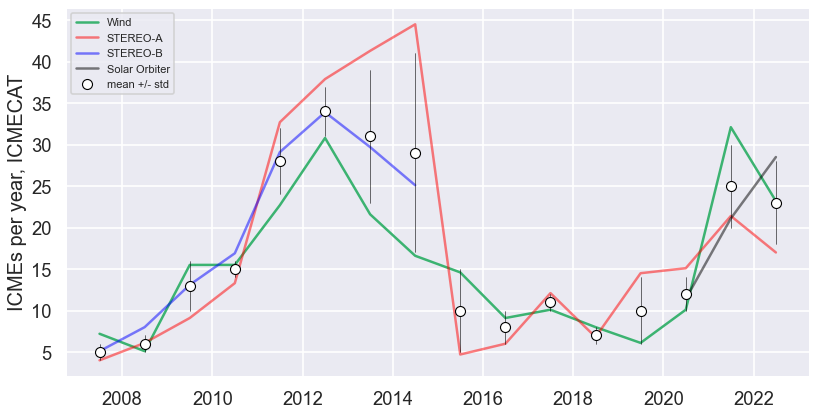

In [7]:
#define dates of January 1 from 2007 to 2022
years_jan_1_str_plus1=[str(i)+'-01-01' for i in np.arange(2007,last_year+1) ] 
yearly_bin_edges=parse_time(years_jan_1_str_plus1).plot_date
#bin width in days         
binweite=365/4

#(histmes1, bin_edgesmes) = np.histogram(parse_time(ic.icme_start_time[mesi]).plot_date, yearly_bin_edges)
#(histmav1, bin_edgesmav) = np.histogram(parse_time(ic.icme_start_time[mavi]).plot_date, yearly_bin_edges)
#(histpsp1, bin_edgespsp) = np.histogram(parse_time(ic.icme_start_time[pspi]).plot_date, yearly_bin_edges)
#(histbepi1, bin_edgesbepi) = np.histogram(parse_time(ic.icme_start_time[beci]).plot_date, yearly_bin_edges)

#(histvex1, bin_edgesvex) = np.histogram(parse_time(ic.icme_start_time[vexi]).plot_date, yearly_bin_edges)
(histstb1, bin_edgesstb) = np.histogram(parse_time(ic.icme_start_time[stbi]).plot_date, yearly_bin_edges)
(histwin1, bin_edgeswin) = np.histogram(parse_time(ic.icme_start_time[wini]).plot_date, yearly_bin_edges)
(histsta1, bin_edgessta) = np.histogram(parse_time(ic.icme_start_time[stai]).plot_date, yearly_bin_edges)
(histsolo1, bin_edgessolo) = np.histogram(parse_time(ic.icme_start_time[soli]).plot_date, yearly_bin_edges)

binedges=bin_edgeswin

#normalize each dataset for data gaps, so correcting ICME rate for actual data availability
#note that for VEX and MESSENGER this was done with the non-removed datasets (vexnon, mesnon)
#histvex=np.round(histvex1/total_data_days_yearly_vex*365.24,1)
#histmes=np.round(histmes1/total_data_days_yearly_mes*365.24,1)

#ok for these spacecraft as continously in the solar wind and the MAVEN data set is made without orbit gaps
#STA beacon data used in 2019 - set manually
#histsta[-3]=13
#STA beacon data used in 2020 - set manually
#histsta[-2]=10*4/3
#histmav=np.round(histmav1/total_data_days_yearly_mav*365.24,1)
#histmav[7]=np.nan #not enough data for 2014
#histpsp=np.round(histpsp1/total_data_days_yearly_psp*365.24,1)
#histbepi=np.round(histbepi1/total_data_days_yearly_bepi*365.24,1)

histsta=np.round(histsta1/total_data_days_yearly_sta*365.24,1)
histstb=np.round(histstb1/total_data_days_yearly_stb*365.24,1)
histwin=np.round(histwin1/total_data_days_yearly_win*365.24,1)
histsolo=np.round(histsolo1/total_data_days_yearly_solo*365.24,1)




print('corrected ICME rates for years')
print(yearly_mid_times)
print('Wind',histwin)
print('STA',histsta)
print('STB',histstb)
print('SolO',histsolo)

#print('VEX',histvex)
#print('MESSENGER',histmes)
#print('PSP',histpsp)
#print('MAVEN',histmav)



################### calculate general parameters


print()
print()
print('calculate ICME rate matrix std, mean, max, min')

#arrange icmecat rate data so each row contains std, mean, max, min

icrate=pd.DataFrame(np.zeros([len(yearly_mid_times),7]), columns=['year','year_date', 'median1','mean1', 'std1', 'max1', 'min1'] )


for i in np.arange(0,len(yearly_mid_times)):
    
    icrate.at[i,'year']=yearly_mid_times_num[i]
    icrate.at[i,'year_date']=yearly_mid_times[i].year
    
    icrate.at[i,'median1']=np.round( np.nanmedian([histwin[i],histsta[i],histstb[i],histsolo[i]])  )
    icrate.at[i,'mean1']=np.round(np.nanmean([histwin[i],histsta[i],histstb[i],histsolo[i]]))
    icrate.at[i,'std1']=np.round(np.nanstd([histwin[i],histsta[i],histstb[i],histsolo[i]]))
    icrate.at[i,'max1']=np.nanmax([histwin[i],histsta[i],histstb[i],histsolo[i]])
    icrate.at[i,'min1']=np.nanmin([histwin[i],histsta[i],histstb[i],histsolo[i]])

#--------

sns.set_context("talk")     
sns.set_style('darkgrid')

plt.figure(11,figsize=(12,6),dpi=80)

plt.ylabel('ICMEs per year, ICMECAT')

#plt.plot(yearly_mid_times,histmes,'-',label='MESSENGER')
#plt.plot(yearly_mid_times,histmav,'-',label='MAVEN')
#plt.plot(yearly_mid_times,histpsp,'-',label='PSP')
#plt.plot(yearly_mid_times,histbepi,'-',label='BepiColombo')
#plt.plot(yearly_mid_times,histvex,'-',label='VEX')

plt.plot(yearly_mid_times,histwin,'-',label='Wind', color='mediumseagreen')
plt.plot(yearly_mid_times,histsta,'-',label='STEREO-A', color='red',alpha=0.5)
plt.plot(yearly_mid_times,histstb,'-',label='STEREO-B', color='blue',alpha=0.5)
plt.plot(yearly_mid_times,histsolo,'-',label='Solar Orbiter', color='black',alpha=0.5)

   
plt.plot([icrate.year,icrate.year],[icrate.mean1-icrate.std1,icrate.mean1+icrate.std1],'-k',lw=0.5)
plt.plot(icrate.year,icrate.mean1,'ok',markerfacecolor='white', label='mean +/- std')


plt.legend(loc=2,fontsize=10)

In [8]:
icrate


,year,year_date,median1,mean1,std1,max1,min1
0,13695.0,2007.0,5.0,5.0,1.0,7.2,4.0
1,14061.0,2008.0,6.0,6.0,1.0,8.0,5.1
2,14426.0,2009.0,13.0,13.0,3.0,15.5,9.1
3,14791.0,2010.0,16.0,15.0,1.0,16.9,13.3
4,15156.0,2011.0,29.0,28.0,4.0,32.7,22.7
5,15522.0,2012.0,34.0,34.0,3.0,37.9,30.8
6,15887.0,2013.0,30.0,31.0,8.0,41.3,21.6
7,16252.0,2014.0,25.0,29.0,12.0,44.5,16.6
8,16617.0,2015.0,10.0,10.0,5.0,14.6,4.7
9,16983.0,2016.0,8.0,8.0,2.0,9.1,6.0


### get Richardson and Cane ICME rate for comparison

In [9]:
#convert times in dataframe from richardson and cane list to numpy array
r1=np.array(rc_df['Disturbance Y/M/D (UT) (a)'])

#to get ICME rate, go through all rows
rc_year=np.zeros(len(r1))

#extract string and check whether its a viable float and non nan:
for p in np.arange(0,len(r1)):    
    rc_yearstr=str(r1[p,0])    
    if hs.is_float(rc_yearstr[0:4]):
        if np.isfinite(float(rc_yearstr[0:4])):
            rc_year[p]=float(rc_yearstr[0:4]) #rc_year contains all ICME

rc_year.sort() 
rc_icme_per_year=np.trim_zeros(rc_year)
#print(rc_year)


#plot check whats in this array

#sns.set_style('darkgrid')
#fig=plt.figure(12,figsize=(12,5),dpi=80)
#ax11=sns.histplot(rc_icme_per_year,bins=24,kde=None)
#plt.ylabel('ICMEs per year, RC list')

#count all full years from 1996-2022
bins_years=2023-1996

#get yearly ICME rate (use range to get correct numbers)
rc_rate_values=np.histogram(rc_icme_per_year,bins=bins_years,range=(1996,2023))[0]
rc_rate_time=np.histogram(rc_icme_per_year,bins=bins_years,range=(1996,2023))[1][0:-1]



years_jul_1_str_rc=[str(i)+'-07-01' for i in np.arange(1996,2022) ] 
yearly_mid_times_rc=parse_time(years_jul_1_str_rc).datetime
yearly_mid_times_num_rc=parse_time(years_jul_1_str_rc).plot_date
#print(yearly_mid_times_rc)
#plt.figure(2)
#plt.plot(yearly_mid_times_rc,rc_rate_values)


print(rc_rate_values)
print(rc_rate_time)


[ 4 22 36 33 51 48 26 22 21 31 13  2  3 11 15 32 35 25 20 30 13  9  8  7
  4 10 31]
[1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003. 2004. 2005. 2006. 2007.
 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015. 2016. 2017. 2018. 2019.
 2020. 2021. 2022.]


### **Figure 1** plot ICME frequency cycle 24

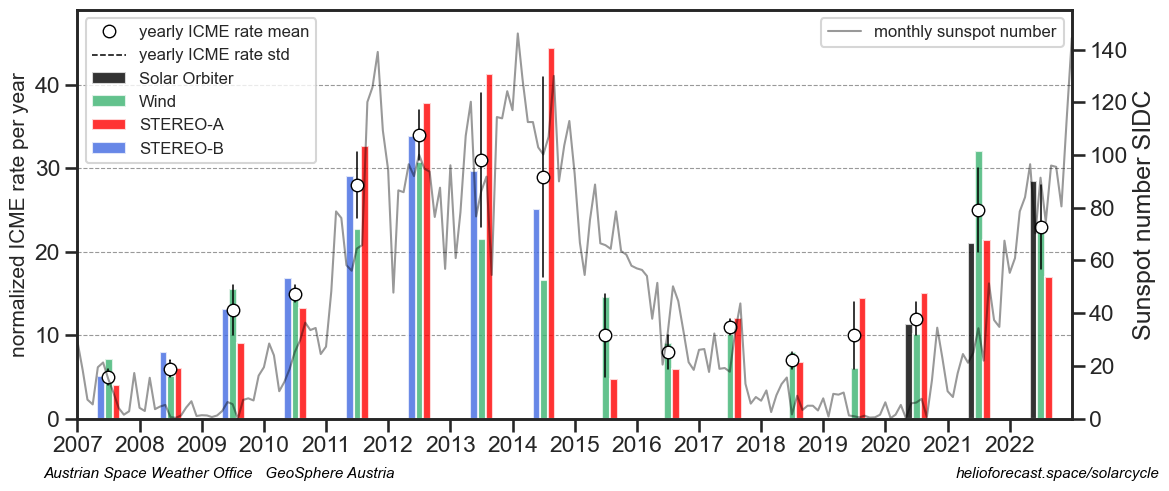

In [29]:
sns.set_context("talk")     
#sns.set_style('whitegrid',{'grid.linestyle': '--'})

sns.set_style("ticks",{'grid.linestyle': '--'})
fsize=15

fig=plt.figure(1,figsize=(12,6),dpi=100)

sns.set_style("ticks",{'grid.linestyle': '--'})

ax2 = plt.subplot(111) 

ax3=ax2.twinx()

#change matplotlib time before plotting
#ssn_time2=ssn.time + mdates.date2num(np.datetime64('0000-12-31'))

ax3.plot(ssn_m.time,ssn_m.spot,'-k',alpha=0.4,linewidth=1.5,label='monthly sunspot number',zorder=0)
ax3.set_ylabel('Sunspot number SIDC')
ax3.set_ylim(0,155)
ax3.legend(loc=1,fontsize=12)

#grid for icme rate
for i in np.arange(0,100,10):
    ax2.plot([datetime.datetime(2007,1,1),datetime.datetime(2035,1,1)],np.zeros(2)+i,linestyle='--',color='k',alpha=0.4,lw=0.8,zorder=0)

binweite=int(np.round(360/8))
bin_edges=bin_edgeswin[:-1]

bin_edges2=bin_edges 

alp=0.8

ax2.bar(bin_edges2+5+binweite*3,histsolo, width=binweite,color='black', alpha=alp,label='Solar Orbiter', zorder=1)
ax2.bar(bin_edges2+5+binweite*4,histwin, width=binweite,color='mediumseagreen', alpha=alp,label='Wind', zorder=1)
ax2.bar(bin_edges2+5+binweite*5,histsta, width=binweite,color='red', alpha=alp,label='STEREO-A',zorder=1)
ax2.bar(bin_edges2+5+binweite*3,histstb, width=binweite,color='royalblue', alpha=alp,label='STEREO-B',zorder=1)


#ax2.bar(bin_edges2+5+binweite,histmes, width=binweite,color='coral', alpha=alp,label='MESSENGER')
#ax2.bar(bin_edges2+5+binweite*2,histvex, width=binweite,color='orange', alpha=alp,label='VEX')
#ax2.bar(bin_edges2+5+binweite*2,histbepi, width=binweite,color='lightgrey', alpha=alp,label='BepiColombo')
#ax2.bar(bin_edges2+5+binweite*6,histpsp, width=binweite,color='black', alpha=alp,label='PSP')
#ax2.bar(bin_edges2+5+binweite*7,histmav, width=binweite,color='steelblue', alpha=alp,label='MAVEN')
#ax2.bar(bin_edgeswin[:-1]+5+binweite*3,rc_rate_values[-14:-1], width=binweite,color='darkgreen', alpha=0.8,label='Wind')

#ax2.boxplot(histmes)
#RC values
#ax2.plot(bin_edgeswin[:-1]+5+binweite*3,rc_rate_values[-14:-1],'ok',markerfacecolor='white',marker='o',markersize=5,label='Earth RC list')

#mean and standard deviation and min max
ax2.plot([icrate.year,icrate.year],[icrate.mean1-icrate.std1,icrate.mean1+icrate.std1],'-k',lw=1.1,zorder=3)

#ax2.plot([icrate.year,icrate.year],[icrate.min1,icrate.max1],'--k',lw=1.1)
ax2.plot(icrate.year,icrate.mean1,'ok',markerfacecolor='white',label='yearly ICME rate mean',zorder=3)
ax2.plot([icrate.year[1],icrate.year[1]],[icrate.mean1[1]-icrate.std1[1],icrate.mean1[1]+icrate.std1[1]],'--k',lw=1.1,label='yearly ICME rate std')

ax2.set_ylim(0,np.max(icrate.mean1)+15)
ax2.set_xlim(yearly_bin_edges[0],yearly_bin_edges[-1])
ax2.legend(loc=2,fontsize=12)

fsize=15
ax2.set_ylabel('normalized ICME rate per year',fontsize=fsize)
#ax2.set_yticks(fontsize=fsize) 

ax2.xaxis_date()
myformat = mdates.DateFormatter('%Y')
ax2.xaxis.set_major_formatter(myformat)
plt.xticks(yearly_start_times, fontsize=fsize) 
plt.xlabel('Year',fontsize=fsize)


    
plt.figtext(0.05,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.98,0.01,'helioforecast.space/solarcycle', color='black', ha='right',fontsize=fsize-4, style='italic')

plt.tight_layout()

#plt.annotate('(a)',[0.01,0.96],xycoords='figure fraction')
#plt.annotate('(b)',[0.01,0.47],xycoords='figure fraction')

#plt.savefig('results/cycle25_icme_rate.pdf', dpi=100)
plt.savefig(outputdirectory+'/icmecat_icme_rate.png', dpi=150)



# 3 get solar cycle results on ICME rates and sunspot numbers

## solar cycle 23

In [11]:
print('cycle 23\n')


############################# times
print('times:')
#these years cover solar cycle 23
years23=np.arange(1996,2009)
print(years23)

last_year=years23[-1] 

years_jan_1_str_23=[str(i)+'-01-01' for i in np.arange(1996,last_year+1) ] 
yearly_start_times_23=parse_time(years_jan_1_str_23).datetime
yearly_start_times_num_23=parse_time(years_jan_1_str_23).plot_date

#same for July 1 as middle of the year
years_jul_1_str_23=[str(i)+'-07-01' for i in np.arange(1996,last_year+1) ] 
yearly_mid_times_23=parse_time(years_jul_1_str_23).datetime
yearly_mid_times_num_23=parse_time(years_jul_1_str_23).plot_date


print(yearly_mid_times_23)

#same for december 31
years_dec_31_str_23=[str(i)+'-12-31' for i in np.arange(1996,last_year+1) ] 
yearly_end_times_23=parse_time(years_dec_31_str_23).datetime
yearly_end_times_num_23=parse_time(years_dec_31_str_23).plot_date


# minimim maximum times as given by
#http://www.sidc.be/silso/cyclesmm
#1996   08   11.2   2001 11  180.3   12  04

solarmin23=parse_time('1996-08-01').datetime
# minstart_23=solarmin_23-datetime.timedelta(days=366*1.5)
# minend=solarmin+datetime.timedelta(days=365)
# minstart_num=parse_time(minstart).plot_date
# minend_num=parse_time(minend).plot_date

solarmax23=parse_time('2001-11-01').datetime
# maxstart=solarmax-datetime.timedelta(days=365*3)
# maxend=solarmax+datetime.timedelta(days=365/2)
# maxstart_num=parse_time(maxstart).plot_date
# maxend_num=parse_time(maxend).plot_date

print('min/max',solarmin23,solarmax23)
print()


#################### spots 
#get yearly smoothed 12 month spot rate 

spots23=np.zeros(len(years23))
counter=0
for q in years23:
    spots23[counter]=np.mean(ssn.spot[np.where(ssn.year==q)[0] ] )
    counter=counter+1

print('spots:')
print('spots yearly mean', np.rint(spots23))
print()


#################### ICME rate
#number of MFR events in Wind ICME catalog, 
#for years as in yearly_mid_times_23 but start aug 1996 and end with 
#nov 2008 #note : halloween events at ACE! Wind not?
wind_mfr_number_23=[2,8,29,11,30,21,20,6,12,16,13,7,3]
#wind_mfr_number_23_err=[2,8,29,11,30,21,20,6,12,16,13,7,3]


rc_rate23=rc_rate_values[0:13]


print('icme rate:')
print('icmes RC',rc_rate23)
print()

cycle 23

times:
[1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008]
[datetime.datetime(1996, 7, 1, 0, 0) datetime.datetime(1997, 7, 1, 0, 0)
 datetime.datetime(1998, 7, 1, 0, 0) datetime.datetime(1999, 7, 1, 0, 0)
 datetime.datetime(2000, 7, 1, 0, 0) datetime.datetime(2001, 7, 1, 0, 0)
 datetime.datetime(2002, 7, 1, 0, 0) datetime.datetime(2003, 7, 1, 0, 0)
 datetime.datetime(2004, 7, 1, 0, 0) datetime.datetime(2005, 7, 1, 0, 0)
 datetime.datetime(2006, 7, 1, 0, 0) datetime.datetime(2007, 7, 1, 0, 0)
 datetime.datetime(2008, 7, 1, 0, 0)]
min/max 1996-08-01 00:00:00 2001-11-01 00:00:00

spots:
spots yearly mean [ 12.  29.  88. 136. 174. 170. 164.  99.  65.  46.  25.  13.   4.]

icme rate:
icmes RC [ 4 22 36 33 51 48 26 22 21 31 13  2  3]



## solar cycle 24

In [12]:
print('cycle 24\n')

#################### times
print('times:')
#these years cover solar cycle 24
years24=np.arange(2009,2020)
print(years24)

#same for July 1 as middle of the year
last_year=2020
years_jul_1_str_24=[str(i)+'-07-01' for i in np.arange(2009,last_year) ] 
yearly_mid_times_24=parse_time(years_jul_1_str_24).datetime
yearly_mid_times_num_24=parse_time(years_jul_1_str_24).plot_date
print(yearly_mid_times_24)
print()


#################### spots 
print('spots:')

#get yearly smoothed 12 month spot rate 
spots24=np.zeros(len(years24))
counter=0
for q in years24:
    spots24[counter]=np.mean(ssn.spot[np.where(ssn.year==q)[0] ] )
    counter=counter+1

print('spots yearly mean:', np.rint(spots24))
print()

print('----------')

################# ICME rates
print('ICME rate:')
print()

#2008 to 2019 are indices 12:24
rc_rate24=rc_rate_values[13:24]
print(years24)
print('icmes RC',rc_rate24)
print()

#here also from 2008 to 2019
ic_rate24=icrate[2:13].mean1.to_numpy()
ic_rate24_std=icrate[2:13].std1.to_numpy()
print('icmes ICMECAT mean',ic_rate24)
print('icmes ICMECAT std',ic_rate24_std)
icrate_years_24=parse_time(mdates.num2date(icrate.year[2:13])).iso
print(icrate_years_24)

print()
print('ratio RC to ICMECAT:')
print(np.round(np.mean(rc_rate24/ic_rate24),2))

cycle 24

times:
[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019]
[datetime.datetime(2009, 7, 1, 0, 0) datetime.datetime(2010, 7, 1, 0, 0)
 datetime.datetime(2011, 7, 1, 0, 0) datetime.datetime(2012, 7, 1, 0, 0)
 datetime.datetime(2013, 7, 1, 0, 0) datetime.datetime(2014, 7, 1, 0, 0)
 datetime.datetime(2015, 7, 1, 0, 0) datetime.datetime(2016, 7, 1, 0, 0)
 datetime.datetime(2017, 7, 1, 0, 0) datetime.datetime(2018, 7, 1, 0, 0)
 datetime.datetime(2019, 7, 1, 0, 0)]

spots:
spots yearly mean: [  5.  25.  81.  85.  94. 113.  70.  40.  22.   7.   4.]

----------
ICME rate:

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019]
icmes RC [11 15 32 35 25 20 30 13  9  8  7]

icmes ICMECAT mean [13. 15. 28. 34. 31. 29. 10.  8. 11.  7. 10.]
icmes ICMECAT std [ 3.  1.  4.  3.  8. 12.  5.  2.  1.  1.  4.]
['2009-07-01 00:00:00.000' '2010-07-01 00:00:00.000'
 '2011-07-01 00:00:00.000' '2012-07-01 00:00:00.000'
 '2013-07-01 00:00:00.000' '2014-07-01 00:00:00.000'
 '2015-07-01 00:00:00.000

## solar cycle 25

In [13]:
print('cycle 25\n')

#################### times from 2020 onwards
print('times:')
#these years cover solar cycle 24
years25=np.arange(2020,2022)
print(years25)

#same for July 1 as middle of the year
last_year=2022
years_jul_1_str_25=[str(i)+'-07-01' for i in np.arange(2020,last_year) ] 
yearly_mid_times_25=parse_time(years_jul_1_str_25).datetime
yearly_mid_times_num_25=parse_time(years_jul_1_str_25).plot_date
print(yearly_mid_times_25)
print()


#################### spots 
print('spots:')

#get yearly smoothed 12 month spot rate 
spots25=np.zeros(len(years25))
counter=0
for q in years25:
    spots25[counter]=np.mean(ssn.spot[np.where(ssn.year==q)[0] ] )
    counter=counter+1

print('spots yearly mean:', np.rint(spots25))
print()

print('----------')

################# ICME rates
print('ICME rate:')
print()

#2020 is index 25
rc_rate25=rc_rate_values[24:26]
print(years25)
print('icmes RC',rc_rate25)
print()

ic_rate25=icrate[13:len(icrate)].mean1.to_numpy()
ic_rate25_std=icrate[13:len(icrate)].std1.to_numpy()
print('icmes ICMECAT mean',ic_rate25)
print('icmes ICMECAT std',ic_rate25_std)
icrate_years_25=parse_time(mdates.num2date(icrate.year[13:len(icrate)])).iso
print(icrate_years_25)

print()
#print('ratio RC to ICMECAT:')
#print(np.round(np.mean(rc_rate24/ic_rate24),2))

cycle 25

times:
[2020 2021]
[datetime.datetime(2020, 7, 1, 0, 0) datetime.datetime(2021, 7, 1, 0, 0)]

spots:
spots yearly mean: [ 9. 30.]

----------
ICME rate:

[2020 2021]
icmes RC [ 4 10]

icmes ICMECAT mean [12. 25. 23.]
icmes ICMECAT std [2. 5. 5.]
['2020-07-01 00:00:00.000' '2021-07-01 00:00:00.000'
 '2022-07-01 00:00:00.000']



## **Figure 2** correlation SSN with ICME rate and fit
plot SSN vs ICME rate, linear fit with confidence interval

linear fit SSN vs. ICME rate
LinregressResult(slope=0.20722307012537758, intercept=7.993116551207326, rvalue=0.842720382432724, pvalue=2.3792727901374683e-07, stderr=0.028223391965670405, intercept_stderr=2.398828648967335)
icme_rate[per year] = ( 0.207 +/- 0.028 ) * sunspot number [yearly average] +  7.993
inverse slope: 4.83
Pearson correlation coefficient: 0.84
mean difference icme rate SC23 to predicted rate with linear fit, over full cycle: 0.33 +/- 8.2
mean difference icme rate SC24 to predicted rate with linear fit, over full cycle: -0.39 +/- 5.8

mean stddev for both cycles gives a 1 sigma spread in the linear fit 7.993116551207326 +/- 6.985767736924602



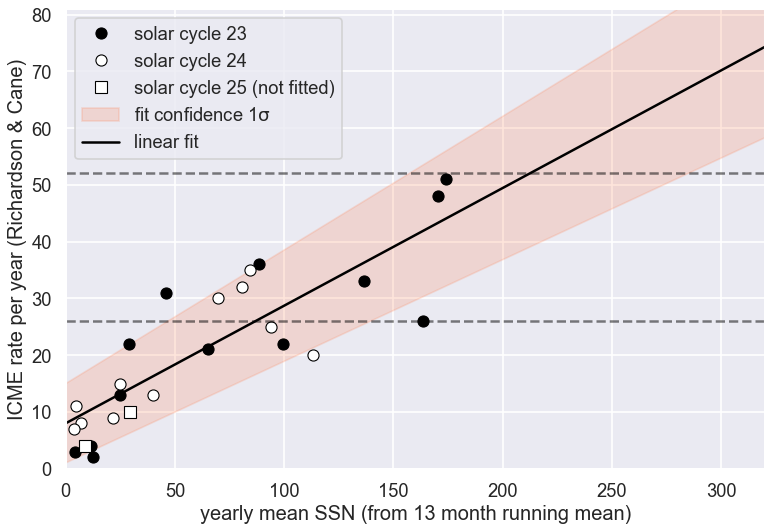

In [14]:
#add spots23/24 and rc_rate23/24 into 1 array for correlation
spots_corr=np.hstack([spots23,spots24])
rc_rate_corr=np.hstack([rc_rate23,rc_rate24])

#quick check with seaborn for correlation
#seaborn uses this :import statsmodels
#kind{ “scatter” | “reg” | “resid” | “kde” | “hex” }, optional
#sns.jointplot(spots_corr,rc_rate_corr,kind='reg',xlim=[0,np.max(spots_corr)+20],ylim=[0,np.max(rc_rate_corr+10)], \
#                  marginal_kws=dict(bins=5, rug=True),x_ci=95).set_axis_labels("yearly mean SSN (12 month running mean)", "ICME rate (Richardson & Cane)")


############################## make linear fit
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
print('linear fit SSN vs. ICME rate')
linfit=scipy.stats.linregress(spots_corr,rc_rate_corr)
print(linfit)
print('icme_rate[per year] = (',np.round(linfit.slope,3),'+/-',np.round(linfit.stderr,3),') * sunspot number [yearly average] + ',np.round(linfit.intercept,3))
print('inverse slope:',np.round(1/linfit.slope,2))
print('Pearson correlation coefficient:',np.round(linfit.rvalue,2))

######################### Function for conversion SSN to ICMERATE, with errors on fit confidence 1 time std

#with these results from the linear fit, make a conversion function from ssn to icme_rate
#old
#def ssn_to_rate(ssn,fitresult):    
#    rate=linfit.slope*ssn+linfit.intercept    
#    rate_low=(linfit.slope-1*linfit.stderr)*ssn+linfit.intercept    
#    rate_up=(linfit.slope+1*linfit.stderr)*ssn+linfit.intercept    
#    return rate, rate_low, rate_up



#with these results from the linear fit, make a conversion function from ssn to icme_rate
def ssn_to_rate(ssn,fitresult):    
    rate=linfit.slope*ssn+linfit.intercept    
    rate_low=(linfit.slope-1*linfit.stderr)*ssn+linfit.intercept    
    rate_up=(linfit.slope+1*linfit.stderr)*ssn+linfit.intercept    
    return rate, rate_low, rate_up



print('mean difference icme rate SC23 to predicted rate with linear fit, over full cycle:',  \
      np.round(np.mean(ssn_to_rate(spots23,linfit)[0]-rc_rate23),2),'+/-', \
      np.round(np.std(ssn_to_rate(spots23,linfit)[0]-rc_rate23),1))#
print('mean difference icme rate SC24 to predicted rate with linear fit, over full cycle:',  \
      np.round(np.mean(ssn_to_rate(spots24,linfit)[0]-rc_rate24),2),'+/-', \
      np.round(np.std(ssn_to_rate(spots24,linfit)[0]-rc_rate24),1))#
print()



mean_stddev=np.mean([np.std(ssn_to_rate(spots23,linfit)[0]-rc_rate23),np.std(ssn_to_rate(spots24,linfit)[0]-rc_rate24)])
print('mean stddev for both cycles gives a 1 sigma spread in the linear fit',linfit.intercept,'+/-',    mean_stddev)
print()





#with these results from the linear fit, make a conversion function from ssn to icme_rate
def ssn_to_rate(ssn,fitresult):    
    rate=linfit.slope*ssn+linfit.intercept    
    rate_low=(linfit.slope-1*linfit.stderr)*ssn+linfit.intercept    - mean_stddev
    rate_up=(linfit.slope+1*linfit.stderr)*ssn+linfit.intercept    + mean_stddev
    return rate, rate_low, rate_up



############################ plot figure
sns.set_context("talk")     
sns.set_style('darkgrid')
fsize=15
fig=plt.figure(2,figsize=(10,7),dpi=80)

plt.plot(spots23,rc_rate23,color='black',marker='o',linestyle='',markersize=10,label='solar cycle 23')
plt.plot(spots24,rc_rate24,color='black',markerfacecolor='white',marker='o',linestyle='',markersize=10,label='solar cycle 24')
plt.plot(spots25,rc_rate25,color='black',markerfacecolor='white',marker='s',linestyle='',markersize=10,label='solar cycle 25 (not fitted)')



plt.xlim(0,320)
plt.ylim(0,np.max(rc_rate_corr)+30)
plt.xlabel("yearly mean SSN (from 13 month running mean)")
plt.ylabel("ICME rate per year (Richardson & Cane)")

#errors
#ylinfit_1=(linfit.slope-linfit.stderr)*xlinfit+linfit.intercept
#ylinfit_2=(linfit.slope+linfit.stderr)*xlinfit+linfit.intercept
#plt.plot(xlinfit,ylinfit_1,'--k')
#plt.plot(xlinfit,ylinfit_2,'--k')

#https://seaborn.pydata.org/generated/seaborn.regplot.html
#sns.regplot(spots_corr,rc_rate_corr, x_ci='ci',ci=95,label=r'fit confidence 2$\mathrm{\sigma}$',truncate=False)
#sns.regplot(spots_corr,rc_rate_corr, x_ci='ci',ci=68,label=r'fit confidence 1$\mathrm{\sigma}$',truncate=False)




xlinfit=np.arange(0,350)
#1 sigma interval by using mean difference as +/- to linear fit

ylinfit_1=(linfit.slope+linfit.stderr)*xlinfit+linfit.intercept+mean_stddev
ylinfit_2=(linfit.slope-linfit.stderr)*xlinfit+linfit.intercept-mean_stddev


plt.fill_between(xlinfit,ylinfit_1,ylinfit_2,alpha=0.2,color='coral',label='fit confidence 1$\mathrm{\sigma}$')
#plt.plot(xlinfit,ylinfit_1,'--k')
#plt.plot(xlinfit,ylinfit_2,'--k')



ylinfit=linfit.slope*xlinfit+linfit.intercept
plt.plot(xlinfit,ylinfit,'-k',label='linear fit')
plt.plot(xlinfit,np.zeros(len(xlinfit))+52,'--k',alpha=0.5)
plt.plot(xlinfit,np.zeros(len(xlinfit))+26,'--k',alpha=0.5)

plt.legend(loc=2)
plt.tight_layout()
#plt.savefig(outputdirectory+'/fig2_rate_ssn.pdf', dpi=300)
plt.savefig(outputdirectory+'/fig2_rate_ssn.png', dpi=300)

## predictions for solar cycle 25: SSN and ICME rate
### 1. Mean cycle model

In [15]:
# from heliocats import stats as hs
# importlib.reload(hs) #reload again while debugging

print('---------------------------------')
print('cycle 25')
print()
print('calculate several Hathaway function models for SSN and predict the ICME rate')
print('')
print('---------------------------------')

############# set yearly times
last_year=2033
yearly_start_times_25=[datetime.datetime(y,1,1) for y in np.arange(2020,last_year) ] 
yearly_start_times_num_25=mdates.date2num(yearly_start_times_25)

#same for July 1 as middle of the year

yearly_mid_times_25=[datetime.datetime(y,7,1) for y in np.arange(2020,last_year) ] 
yearly_mid_times_num_25=mdates.date2num(yearly_mid_times_25)

#### for smooth plotting daily list of times
#t0 of solar cycler 25 is unclear at time of writing! assumed 2020 june 1
start_25=datetime.datetime(2020,6,1)
#not end time of next solar cycle, but end time of plotting
end_25=datetime.datetime(2033,1,1)

#create an array with 1 day resolution between t start and end
times_25_daily = [ start_25 + datetime.timedelta(days=n) for n in range(int ((end_25 - start_25).days))]  
times_25_daily_mat=mdates.date2num(times_25_daily) 
######################################################## 1. Mean cycle model

#hathaway 2015: t0 minus 4 months is good match
#t0 is start date of cycle
shift_t0=timedelta(days=4*30+1)

print()
print('1. mean cycle')

#mean of all cycles function: Hathaway 1994
#parameters taken from Hathaway 2015 review section 4.5 DOI 10.1007/lrsp-2015-4
#https://link.springer.com/article/10.1007/lrsp-2015-4
#but this is based on different SSN definitions?
# am=195
# amerr=50
# bm=56
# cm=0.8

print('load min max for all cycles from SILSO')

#http://sidc.oma.be/silso/DATA/Cycles/TableCyclesMiMa.txt
#Table of minima, maxima and cycle durations based on
#13-month smoothed monthly mean sunspot numbers (Version 2.0).
mima_num=np.loadtxt('data/TableCyclesMiMa.txt', skiprows=2)
mima = pd.DataFrame(mima_num)
mima.columns = ['cycle','min_year','min_month','min_sn','max_year','max_month','max_sn','dur_year','dur_months']

print()
print('Average maximum sunspot number (SILSO) of all cycles, 13 months smoothed:',np.round(mima.max_sn.mean(),1),' +/- ',np.round(mima.max_sn.std(),1))
print()

#use all parameters as in Hathaway but adjust amplitude to average for the SILSO numbers:
am=342
bm=56
cm=0.8
print('average cycle a,b,c:', am,bm,cm)


#mean of all cycles yearly ssn numbers 
spots_predict_25m=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,am,bm,cm)
#and same for 1 day resolution 
spots_predict_25m_daily=hs.hathaway(times_25_daily, start_25-shift_t0,am,bm,cm)

print('t0 in SC25 PP prediction is:',start_25-shift_t0)
#time of maximum and ssn
print('max ssn',np.rint(np.max(spots_predict_25m_daily)))
print('at time',str(times_25_daily[np.argmax(spots_predict_25m_daily)])[0:11])
print()
print(yearly_mid_times_25)
print('spots yearly: ',np.rint(spots_predict_25m))

#yearly icme numbers: convert with function
icmes_predict_25m=ssn_to_rate(spots_predict_25m,linfit)[0]
#same daily resolution
icmes_predict_25m_daily=ssn_to_rate(spots_predict_25m_daily,linfit)[0]



print('icmes yearly: ',np.rint(icmes_predict_25m))

print()
print()
print('Merge error from 1. ssn prediction from fit with 2. spread in icme rate observed with ICMECAT (not used in plots later as PP19 is quite similar)')

#1. error from SSN fit yearly, low and high
icmes_predict_25m_low=ssn_to_rate(spots_predict_25m,linfit)[1]
icmes_predict_25m_high=ssn_to_rate(spots_predict_25m,linfit)[2]

#this is the range in the icme rate arising from the fit, symmetric for high and low values 
ic_rate25_m_std_fit=np.round(icmes_predict_25m-icmes_predict_25m_low,1)
print('error from SSN to ICME fit',ic_rate25_m_std_fit)

#2. error from ICME rate
#assumption icrate_std=2 for last 3 years
ic_rate25_std=np.hstack([ic_rate24_std[0:-1],np.array([2.0,2.0,2.0])])
print('spread in ICME rate from SC24, assuming 2009=> 2020',ic_rate25_std)

#add both errors as sigma_new=sqrt(sigma1^2+sigma2^2)
ic_rate_25_m_std=np.round(np.sqrt(ic_rate25_m_std_fit**2+ic_rate25_std**2),1)
print('Std in ICME rate from fit and ICMECAT range for each year:')
print(ic_rate_25_m_std)

---------------------------------
cycle 25

calculate several Hathaway function models for SSN and predict the ICME rate

---------------------------------

1. mean cycle
load min max for all cycles from SILSO

Average maximum sunspot number (SILSO) of all cycles, 13 months smoothed: 178.7  +/-  57.8

average cycle a,b,c: 342 56 0.8
t0 in SC25 PP prediction is: 2020-02-01 00:00:00
max ssn 179.0
at time 2024-12-23 

[datetime.datetime(2020, 7, 1, 0, 0), datetime.datetime(2021, 7, 1, 0, 0), datetime.datetime(2022, 7, 1, 0, 0), datetime.datetime(2023, 7, 1, 0, 0), datetime.datetime(2024, 7, 1, 0, 0), datetime.datetime(2025, 7, 1, 0, 0), datetime.datetime(2026, 7, 1, 0, 0), datetime.datetime(2027, 7, 1, 0, 0), datetime.datetime(2028, 7, 1, 0, 0), datetime.datetime(2029, 7, 1, 0, 0), datetime.datetime(2030, 7, 1, 0, 0), datetime.datetime(2031, 7, 1, 0, 0), datetime.datetime(2032, 7, 1, 0, 0)]
spots yearly:  [  1.  32.  93. 147. 176. 176. 153. 117.  80.  49.  26.  13.   5.]
icmes yearly:  [ 

---------------------------- 2. SC25 PP 2019

get PP25 prediction from JSON file from NOAA (2020 May 27) 
Hathaway function fit parameters x0,a,b,c: [-253.   256.    60.3] 0.35
t0 in SC25 PP prediction is: 2019-08-22 00:00:00+00:00
lower error: Hathaway function fit parameters x0,a,b,c: [-22.6 228.2  54.4] 0.48
higher error: Hathaway function fit parameters x0,a,b,c: [-492.1  273.3   67.4] 0.34
note that high and low error ranges are calculated here with a Hathaway function, small error to PP forecast
max ssn 115.0
at time 2025-07-03 

spots yearly:  [  2.  16.  46.  80. 106. 115. 107.  87.  63.  41.  24.  13.   6.]

Merge error from 1. ssn prediction 2. from SSN to ICME from fit and 3. spread in icme rate observed with ICMECAT
ICME rate error from SSN prediction [0.75 2.09 2.56 2.16 1.69 1.65 2.   2.43 2.63 2.46 1.99 1.41 0.89]
error from SSN to ICME fit [ 7.   7.4  8.3  9.2 10.  10.2 10.   9.5  8.8  8.2  7.7  7.3  7.2]
spread in ICME rate [ 3.  1.  4.  3.  8. 12.  5.  2.  1.  1.  2. 

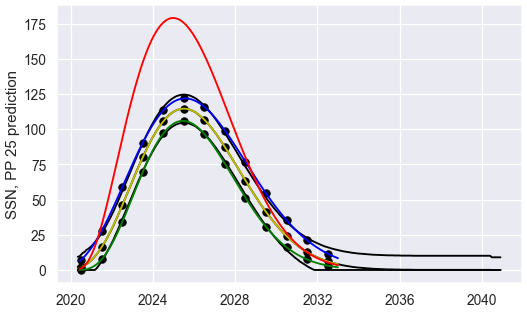

In [16]:
########################################################### 2. SC25 panel prediction (SC25PP)
print('---------------------------- 2. SC25 PP 2019')
print()
print('get PP25 prediction from JSON file from NOAA (2020 May 27) ')    

#download PP25 prediction from NOAA with timestamp
#sc25pp_url='https://services.swpc.noaa.gov/json/solar-cycle/predicted-solar-cycle.json'

#try: urllib.request.urlretrieve(sc25pp_url,data_path+'predicted-solar-cycle_2020_may_27.json')
#except urllib.error.URLError as e:
#    print('Failed downloading ', sc25pp_url,' ',e)

pp25_df=pd.read_json('data/predicted-solar-cycle_2020_may_27.json')

#kill first few rows and start with May 2020 because of bad format
pp25_df=pp25_df.drop([0,1,2,3,4,5],axis=0)
#pp25_df=pp25_df.drop([0,1,2,3,4,5],axis=0)

#pp25_df_times=parse_time(pp25_df['time-tag']).datetime

pp25_df_times=[]

#make datetime objects from file times
for i in np.arange(6,len(pp25_df)+6): 
    year=int(pp25_df['time-tag'][i][0:4])
    month=int(pp25_df['time-tag'][i][5:7])
    day=int(pp25_df['time-tag'][i][8:9])
    pp25_df_times.append(datetime.datetime(year,month,day))

pp25_df_times_num=mdates.date2num(pp25_df_times)

pp25_df_ssn=pp25_df['predicted_ssn']
pp25_df_ssn_high=pp25_df['high_ssn']
pp25_df_ssn_low=pp25_df['low_ssn']


#make hathaway fit
hw_param_pp25 = scipy.optimize.curve_fit(hs.hathaway_fit, pp25_df_times_num-pp25_df_times_num[0],pp25_df_ssn, p0=[-300,200,60,1])    
print('Hathaway function fit parameters x0,a,b,c:',np.round(hw_param_pp25[0][0:3],1),np.round(hw_param_pp25[0][3],2))
#get t0 date for hathway function from fit x0
x0fit_in_days=int(np.rint(hw_param_pp25[0][0]))

start_25_fit=mdates.num2date(pp25_df_times_num[0])+timedelta(days=x0fit_in_days)
print('t0 in SC25 PP prediction is:',start_25_fit)

# same for low and high
hw_param_pp25_low = scipy.optimize.curve_fit(hs.hathaway_fit, pp25_df_times_num-pp25_df_times_num[0],pp25_df_ssn_low,\
                                        p0=[-300,200,60,1])    
x0fit_in_days_low=int(np.rint(hw_param_pp25_low[0][0]))
start_25_fit_low=mdates.num2date(pp25_df_times_num[0])+timedelta(days=x0fit_in_days_low)
print('lower error: Hathaway function fit parameters x0,a,b,c:',np.round(hw_param_pp25_low[0][0:3],1),np.round(hw_param_pp25_low[0][3],2))

hw_param_pp25_high = scipy.optimize.curve_fit(hs.hathaway_fit, pp25_df_times_num-pp25_df_times_num[0],pp25_df_ssn_high,\
                                        p0=[-300,200,60,1])    
x0fit_in_days_high=int(np.rint(hw_param_pp25_high[0][0]))
start_25_fit_high=mdates.num2date(pp25_df_times_num[0])+timedelta(days=x0fit_in_days_high)
print('higher error: Hathaway function fit parameters x0,a,b,c:',np.round(hw_param_pp25_high[0][0:3],1),np.round(hw_param_pp25_high[0][3],2))
print('note that high and low error ranges are calculated here with a Hathaway function, small error to PP forecast')


spots_predict_25pp=hs.hathaway(yearly_mid_times_25,start_25_fit,hw_param_pp25[0][1],hw_param_pp25[0][2],hw_param_pp25[0][3])
spots_predict_25pp_daily=hs.hathaway(times_25_daily,start_25_fit,hw_param_pp25[0][1],hw_param_pp25[0][2],hw_param_pp25[0][3])





#fit parameters for PP19
#start_25_fit
app=hw_param_pp25[0][1]
bpp=hw_param_pp25[0][2]
cpp=hw_param_pp25[0][3]

spots_predict_25pp_low=hs.hathaway(yearly_mid_times_25,start_25_fit_low,hw_param_pp25_low[0][1],hw_param_pp25_low[0][2],hw_param_pp25_low[0][3])
spots_predict_25pp_daily_low=hs.hathaway(times_25_daily,start_25_fit_low,hw_param_pp25_low[0][1],hw_param_pp25_low[0][2],hw_param_pp25_low[0][3])
spots_predict_25pp_high=hs.hathaway(yearly_mid_times_25,start_25_fit_high,hw_param_pp25_high[0][1],hw_param_pp25_high[0][2],hw_param_pp25_high[0][3])
spots_predict_25pp_daily_high=hs.hathaway(times_25_daily,start_25_fit_high,hw_param_pp25_high[0][1],hw_param_pp25_high[0][2],hw_param_pp25_high[0][3])

plt.figure(12,figsize=(10,6),dpi=60)
plt.plot(pp25_df_times,pp25_df_ssn,'-k',markerfacecolor='white')
plt.plot(pp25_df_times,pp25_df['high_ssn'],'-k',markerfacecolor='white')
plt.plot(pp25_df_times,pp25_df['low_ssn'],'-k',markerfacecolor='white')
plt.plot_date(yearly_mid_times_25,spots_predict_25pp,'ok')
plt.plot_date(times_25_daily,spots_predict_25pp_daily,'-y')
plt.plot_date(yearly_mid_times_25,spots_predict_25pp_low,'ok')
plt.plot_date(yearly_mid_times_25,spots_predict_25pp_high,'ok')
plt.plot_date(times_25_daily,spots_predict_25pp_daily_low,'-g')
plt.plot_date(times_25_daily,spots_predict_25pp_daily_high,'-b')
plt.plot_date(times_25_daily,spots_predict_25m_daily,'-r')

plt.ylabel('SSN, PP 25 prediction')
#time of maximum and ssn
print('max ssn',np.rint(np.max(spots_predict_25pp_daily)))
print('at time',str(times_25_daily[np.argmax(spots_predict_25pp_daily)])[0:11])
print()
print('spots yearly: ',np.rint(spots_predict_25pp))


#yearly spots numbers
icmes_predict_25pp=ssn_to_rate(spots_predict_25pp,linfit)[0]
icmes_predict_25pp_low=ssn_to_rate(spots_predict_25pp_low,linfit)[0]
icmes_predict_25pp_high=ssn_to_rate(spots_predict_25pp_high,linfit)[0]

#same daily
icmes_predict_25pp_daily=ssn_to_rate(spots_predict_25pp_daily,linfit)[0]
icmes_predict_25pp_daily_low=ssn_to_rate(spots_predict_25pp_daily_low,linfit)[0]
icmes_predict_25pp_dailyhigh=ssn_to_rate(spots_predict_25pp_daily_high,linfit)[0]


print()
print('Merge error from 1. ssn prediction 2. from SSN to ICME from fit and 3. spread in icme rate observed with ICMECAT')

#1. error from SSN prediction
ic_rate25_std_pp_ssnpred=np.round(((icmes_predict_25pp_high-icmes_predict_25pp)+abs(icmes_predict_25pp_low-icmes_predict_25pp))/2,2)
print('ICME rate error from SSN prediction',ic_rate25_std_pp_ssnpred)


#2. error from fit SSN to ICME rate
icmes_predict_25_pp=ssn_to_rate(spots_predict_25pp,linfit)[0]
icmes_predict_25_pp_low=ssn_to_rate(spots_predict_25pp,linfit)[1]
icmes_predict_25_pp_high=ssn_to_rate(spots_predict_25pp,linfit)[2]

#this is the range in the icme rate arising from the fit, symmetric for high and low values 
ic_rate25_std_pp_ssnfit=np.round(icmes_predict_25_pp-icmes_predict_25_pp_low,1)
print('error from SSN to ICME fit',ic_rate25_std_pp_ssnfit)

#3. error from ICME rate spread
print('spread in ICME rate', ic_rate25_std)

print()
#add all 3 errors as sigma_new=sqrt(sigma1^2+sigma2^2)
ic_rate_25_pp_std=np.round(np.sqrt(ic_rate25_std_pp_ssnpred**2+ic_rate25_std_pp_ssnfit**2+ic_rate25_std**2),1)
print('final Std in ICME rate from SSN prediction, SSN to ICME fit and ICMECAT range for each year:')
print(ic_rate_25_pp_std)

In [17]:
################################### SC25MC
#SC25MC prediction or MC20 (see paper)
#https://arxiv.org/abs/2006.15263


print('-------------------------- 3. SC25 MC 2020')
a=444
aerr68=48 #MC20: 204-254 68, 153 305 95
aerr95=147 #153 305 95, +/- 76 95
b=60
c=0.8



print('a,b,c:', a,b,c)
print('range for a:',a-aerr68,a+aerr68)

print('start of sc25 here in MC23',start_25-shift_t0)

#yearly_numbers
spots_predict_25=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,a,b,c)
#error ranges
spots_predict_25_lower68=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,a-aerr68,b,c)
spots_predict_25_upper68=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,a+aerr68,b,c)
#spots_predict_25_lower95=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,a-aerr95,b,c)
#spots_predict_25_upper95=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,a+aerr95,b,c)



#daily numbers
spots_predict_25_daily=hs.hathaway(times_25_daily, start_25-shift_t0,a,b,c)
#error ranges
spots_predict_25_daily_lower68=hs.hathaway(times_25_daily, start_25-shift_t0,a-aerr68,b,c)
spots_predict_25_daily_upper68=hs.hathaway(times_25_daily, start_25-shift_t0,a+aerr68,b,c)
#spots_predict_25_daily_lower95=hs.hathaway(times_25_daily, start_25-shift_t0,a-aerr95,b,c)
#spots_predict_25_daily_upper95=hs.hathaway(times_25_daily, start_25-shift_t0,a+aerr95,b,c)

#time of maximum and ssn
print('max ssn',np.rint(np.max(spots_predict_25_daily)))
print('at time',str(times_25_daily[np.argmax(spots_predict_25_daily)])[0:11])

print()
print('spots yearly',np.rint(spots_predict_25))

#
#yearly spots numbers
icmes_predict_25mc=ssn_to_rate(spots_predict_25,linfit)[0]
icmes_predict_25mc_lower68=ssn_to_rate(spots_predict_25_lower68,linfit)[0]
icmes_predict_25mc_upper68=ssn_to_rate(spots_predict_25_upper68,linfit)[0]
#icmes_predict_25mc_lower95=ssn_to_rate(spots_predict_25_lower95,linfit)[0]
#icmes_predict_25mc_upper95=ssn_to_rate(spots_predict_25_upper95,linfit)[0]

#same daily
icmes_predict_25mc_daily=ssn_to_rate(spots_predict_25_daily,linfit)[0]
icmes_predict_25mc_daily_lower68=ssn_to_rate(spots_predict_25_daily_lower68,linfit)[0]
icmes_predict_25mc_daily_upper68=ssn_to_rate(spots_predict_25_daily_upper68,linfit)[0]
#icmes_predict_25mc_daily_lower95=ssn_to_rate(spots_predict_25_daily_lower95,linfit)[0]
#icmes_predict_25mc_daily_upper95=ssn_to_rate(spots_predict_25_daily_upper95,linfit)[0]


#1. error from SSN prediction
print()
print('icmes yearly: ',np.rint(icmes_predict_25mc))
print('icmes lower68: ',np.rint(icmes_predict_25mc_lower68))
print('icmes upper68: ',np.rint(icmes_predict_25mc_upper68))

#print('icmes lower95: ',np.rint(icmes_predict_25mc_lower95))
#print('icmes upper95: ',np.rint(icmes_predict_25mc_upper95))


print()
print('Merge error from 1. ssn prediction 2. from SSN to ICME from fit and 3. spread in icme rate observed with ICMECAT')

#1. error from SSN prediction
ic_rate25_std_mc20_ssnpred=np.round(((icmes_predict_25mc_upper68-icmes_predict_25mc)+abs(icmes_predict_25mc_lower68-icmes_predict_25mc))/2,2)
print('ICME rate error from SSN prediction',ic_rate25_std_mc20_ssnpred)


#2. error from fit SSN to ICME rate
icmes_predict_25_mc20=ssn_to_rate(spots_predict_25,linfit)[0]
icmes_predict_25_mc20_low=ssn_to_rate(spots_predict_25,linfit)[1]
icmes_predict_25_mc20_high=ssn_to_rate(spots_predict_25,linfit)[2]

#this is the range in the icme rate arising from the fit, symmetric for high and low values 
ic_rate25_std_mc20_ssnfit=np.round(icmes_predict_25_mc20-icmes_predict_25_mc20_low,1)
print('error from SSN to ICME fit',ic_rate25_std_mc20_ssnfit)

#3. error from ICME rate spread
print('spread in ICME rate', ic_rate25_std)

print()
#add all 3 errors as sigma_new=sqrt(sigma1^2+sigma2^2)
ic_rate_25_mc20_std=np.round(np.sqrt(ic_rate25_std_mc20_ssnpred**2+ic_rate25_std_mc20_ssnfit**2+ic_rate25_std**2),1)
print('final Std in ICME rate from SSN prediction, SSN to ICME fit and ICMECAT range for each year:')
print(ic_rate_25_mc20_std)

-------------------------- 3. SC25 MC 2020
a,b,c: 444 60 0.8
range for a: 396 492
start of sc25 here in MC23 2020-02-01 00:00:00
max ssn 232.0
at time 2025-04-30 

spots yearly [  1.  35. 108. 178. 221. 232. 214. 176. 131.  87.  53.  29.  14.]

icmes yearly:  [ 8. 15. 30. 45. 54. 56. 52. 45. 35. 26. 19. 14. 11.]
icmes lower68:  [ 8. 15. 28. 41. 49. 51. 47. 41. 32. 24. 18. 13. 11.]
icmes upper68:  [ 8. 16. 33. 49. 59. 61. 57. 48. 38. 28. 20. 15. 11.]

Merge error from 1. ssn prediction 2. from SSN to ICME from fit and 3. spread in icme rate observed with ICMECAT
ICME rate error from SSN prediction [0.03 0.79 2.42 3.99 4.96 5.2  4.79 3.95 2.93 1.96 1.18 0.65 0.32]
error from SSN to ICME fit [ 7.   8.  10.  12.  13.2 13.5 13.  12.  10.7  9.5  8.5  7.8  7.4]
spread in ICME rate [ 3.  1.  4.  3.  8. 12.  5.  2.  1.  1.  2.  2.  2.]

final Std in ICME rate from SSN prediction, SSN to ICME fit and ICMECAT range for each year:
[ 7.6  8.1 11.  13.  16.2 18.8 14.7 12.8 11.1  9.8  8.8  8.1  7.7]


In [18]:
################################### SC25MC
#SC25MC prediction or MC20 (see paper)
#https://arxiv.org/abs/2006.15263

#90 ± 20.
#https://spaceweatherarchive.com/2022/02/25/the-termination-event-has-arrived/




print('-------------------------- 4. SC25 MC 2022 based on terminator ')
a=363
aerr68=38 #MC20: 325 -> 170 max, 
b=60#b=60
c=0.8 #c=0.8
print('a,b,c:', a,b,c)
print('range for a:',a-aerr68,a+aerr68)

#shift_t02=timedelta(days=4*30+1+12*30)

shift_t02=timedelta(days=121)
print('start of sc25 here in MC20 v2',start_25-shift_t02)

#yearly_numbers
spots_predict_25_mc2=hs.hathaway(yearly_mid_times_25, start_25-shift_t02,a,b,c)


print()
print()
print()


print('-------------------------- 5. SC25 MC 2023 based on terminator 12/2021')

#MC2023
#sunspot number 184 ±17 at 1σ and ±63 at 2σ

######self
#a=351
#aerr68=33 #for 1sigma
#b=45#60
#c=0.8


########from scott

#tstart = anytim2jd('2019-06-01 00:00.00')

#t0 = 14. ; Hathaway's start time (in months) 

#start is 2020 August 1
#A_TOT = 2.5
#A = A_TOT * 1.85e-3
#B = 24.12 + 28.15 / (A * 1.e3)^0.25 
#C = 0.71

a=365
aerr68=33 #for 1sigma
b=43.3#60
c=0.71

print('a,b,c:', a,b,c)
print('range for a:',a-aerr68,a+aerr68)

#shift_t02=timedelta(days=430+1+12*30)
shift_t03=timedelta(days=-61)
print('start of sc25 here in MC23',start_25-shift_t03)

#yearly_numbers
spots_predict_25_mc23=hs.hathaway(yearly_mid_times_25, start_25-shift_t03,a,b,c)

spots_predict_25_mc23_lower68=hs.hathaway(yearly_mid_times_25, start_25-shift_t03,a-aerr68,b,c)
spots_predict_25_mc23_upper68=hs.hathaway(yearly_mid_times_25, start_25-shift_t03,a+aerr68,b,c)


#check resulting sunspot numbers with daily times

print('max sunspot number in this model')

spots_predict_25_mc23_daily=hs.hathaway(times_25_daily, start_25-shift_t03,a,b,c)
print(np.round(np.max(spots_predict_25_mc23_daily)))

spots_predict_25_mc23_daily_upper68=hs.hathaway(times_25_daily, start_25-shift_t03,a+aerr68,b,c)
print(np.round(np.max(spots_predict_25_mc23_daily_upper68)))


print()
print('time of max sunspot number in this model')
print(times_25_daily[np.argmax(spots_predict_25_mc23_daily)])

#spots_predict_25_mc23_lower68=hs.hathaway(times_25_daily, start_25-shift_t03,a-aerr68,b,c)
#spots_predict_25_mc23_upper68=hs.hathaway(yearly_mid_times_25, start_25-shift_t03,a+aerr68,b,c)



#print(np.round(spots_predict_25_mc23-spots_predict_25_mc23_upper68))


-------------------------- 4. SC25 MC 2022 based on terminator 
a,b,c: 363 60 0.8
range for a: 325 401
start of sc25 here in MC20 v2 2020-02-01 00:00:00



-------------------------- 5. SC25 MC 2023 based on terminator 12/2021
a,b,c: 365 43.3 0.71
range for a: 332 398
start of sc25 here in MC23 2020-08-01 00:00:00
max sunspot number in this model
184.0
201.0

time of max sunspot number in this model
2024-06-25 00:00:00


start of sc25 here in MC23 2020-08-01 00:00:00
max ssn 184.0
at time 2024-06-25 

spots yearly [ -0.  17.  89. 159. 184. 162. 115.  66.  31.  12.   4.   1.   0.]

icmes yearly:  [ 8. 11. 26. 41. 46. 42. 32. 22. 14. 11.  9.  8.  8.]
icmes lower68:  [ 8. 11. 25. 38. 43. 39. 30. 21. 14. 10.  9.  8.  8.]
icmes upper68:  [ 8. 12. 28. 44. 50. 45. 34. 23. 15. 11.  9.  8.  8.]

Merge error from 1. ssn prediction 2. from SSN to ICME from fit and 3. spread in icme rate observed with ICMECAT
ICME rate error from SSN prediction [-0.    0.31  1.66  2.98  3.45  3.04  2.15  1.24  0.59  0.23  0.07  0.02
  0.  ]
error from SSN to ICME fit [ 7.   7.5  9.5 11.5 12.2 11.6 10.2  8.9  7.9  7.3  7.1  7.   7. ]
spread in ICME rate [ 3.  1.  4.  3.  8. 12.  5.  2.  1.  1.  2.  2.  2.]

final Std in ICME rate from SSN prediction, SSN to ICME fit and ICMECAT range for each year:
[ 7.6  7.6 10.4 12.3 15.  17.  11.6  9.2  8.   7.4  7.4  7.3  7.3]


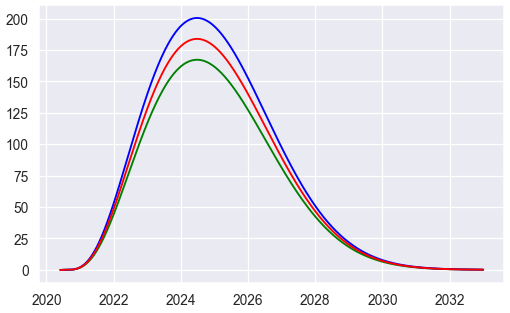

In [19]:
print('start of sc25 here in MC23',start_25-shift_t03)

#yearly_numbers
spots_predict_25_mc3=hs.hathaway(yearly_mid_times_25, start_25-shift_t03,a,b,c)
#error ranges
spots_predict_25_lower68_mc3=hs.hathaway(yearly_mid_times_25, start_25-shift_t03,a-aerr68,b,c)
spots_predict_25_upper68_mc3=hs.hathaway(yearly_mid_times_25, start_25-shift_t03,a+aerr68,b,c)
#spots_predict_25_lower95=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,a-aerr95,b,c)
#spots_predict_25_upper95=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,a+aerr95,b,c)


#daily numbers
spots_predict_25_daily_mc3=hs.hathaway(times_25_daily, start_25-shift_t03,a,b,c)
#error ranges
spots_predict_25_daily_lower68_mc3=hs.hathaway(times_25_daily, start_25-shift_t03,a-aerr68,b,c)
spots_predict_25_daily_upper68_mc3=hs.hathaway(times_25_daily, start_25-shift_t03,a+aerr68,b,c)
#spots_predict_25_daily_lower95=hs.hathaway(times_25_daily, start_25-shift_t0,a-aerr95,b,c)
#spots_predict_25_daily_upper95=hs.hathaway(times_25_daily, start_25-shift_t0,a+aerr95,b,c)


plt.figure(12,figsize=(10,6),dpi=60)
plt.plot_date(times_25_daily,spots_predict_25_daily_lower68_mc3,'-g')
plt.plot_date(times_25_daily,spots_predict_25_daily_upper68_mc3,'-b')
plt.plot_date(times_25_daily,spots_predict_25_daily_mc3,'-r')


#time of maximum and ssn
print('max ssn',np.rint(np.max(spots_predict_25_daily_mc3)))
print('at time',str(times_25_daily[np.argmax(spots_predict_25_daily_mc3)])[0:11])

print()
print('spots yearly',np.rint(spots_predict_25_mc3))

#
#yearly spots numbers
icmes_predict_25mc3=ssn_to_rate(spots_predict_25_mc3,linfit)[0]
icmes_predict_25mc3_lower68=ssn_to_rate(spots_predict_25_lower68_mc3,linfit)[0]
icmes_predict_25mc3_upper68=ssn_to_rate(spots_predict_25_upper68_mc3,linfit)[0]
#icmes_predict_25mc_lower95=ssn_to_rate(spots_predict_25_lower95,linfit)[0]
#icmes_predict_25mc_upper95=ssn_to_rate(spots_predict_25_upper95,linfit)[0]

#same daily
icmes_predict_25mc3_daily=ssn_to_rate(spots_predict_25_daily_mc3,linfit)[0]
icmes_predict_25mc3_daily_lower68=ssn_to_rate(spots_predict_25_daily_lower68_mc3,linfit)[0]
icmes_predict_25mc3_daily_upper68=ssn_to_rate(spots_predict_25_daily_upper68_mc3,linfit)[0]
#icmes_predict_25mc_daily_lower95=ssn_to_rate(spots_predict_25_daily_lower95,linfit)[0]
#icmes_predict_25mc_daily_upper95=ssn_to_rate(spots_predict_25_daily_upper95,linfit)[0]


#1. error from SSN prediction
print()
print('icmes yearly: ',np.rint(icmes_predict_25mc3))
print('icmes lower68: ',np.rint(icmes_predict_25mc3_lower68))
print('icmes upper68: ',np.rint(icmes_predict_25mc3_upper68))

#print('icmes lower95: ',np.rint(icmes_predict_25mc_lower95))
#print('icmes upper95: ',np.rint(icmes_predict_25mc_upper95))


print()
print('Merge error from 1. ssn prediction 2. from SSN to ICME from fit and 3. spread in icme rate observed with ICMECAT')

#1. error from SSN prediction
ic_rate25_std_mc23_ssnpred=np.round(((icmes_predict_25mc3_upper68-icmes_predict_25mc3)+abs(icmes_predict_25mc3_lower68-icmes_predict_25mc3))/2,2)
print('ICME rate error from SSN prediction',ic_rate25_std_mc23_ssnpred)


#2. error from fit SSN to ICME rate
icmes_predict_25_mc23=ssn_to_rate(spots_predict_25_mc3,linfit)[0]
icmes_predict_25_mc23_low=ssn_to_rate(spots_predict_25_mc3,linfit)[1]
icmes_predict_25_mc23_high=ssn_to_rate(spots_predict_25_mc3,linfit)[2]

#this is the range in the icme rate arising from the fit, symmetric for high and low values 
ic_rate25_std_mc23_ssnfit=np.round(icmes_predict_25_mc23-icmes_predict_25_mc23_low,1)
print('error from SSN to ICME fit',ic_rate25_std_mc23_ssnfit)

#3. error from ICME rate spread
print('spread in ICME rate', ic_rate25_std)

print()
#add all 3 errors as sigma_new=sqrt(sigma1^2+sigma2^2)
ic_rate_25_mc23_std=np.round(np.sqrt(ic_rate25_std_mc23_ssnpred**2+ic_rate25_std_mc23_ssnfit**2+ic_rate25_std**2),1)
print('final Std in ICME rate from SSN prediction, SSN to ICME fit and ICMECAT range for each year:')
print(ic_rate_25_mc23_std)



## **Figure 3** ICME rate predictions

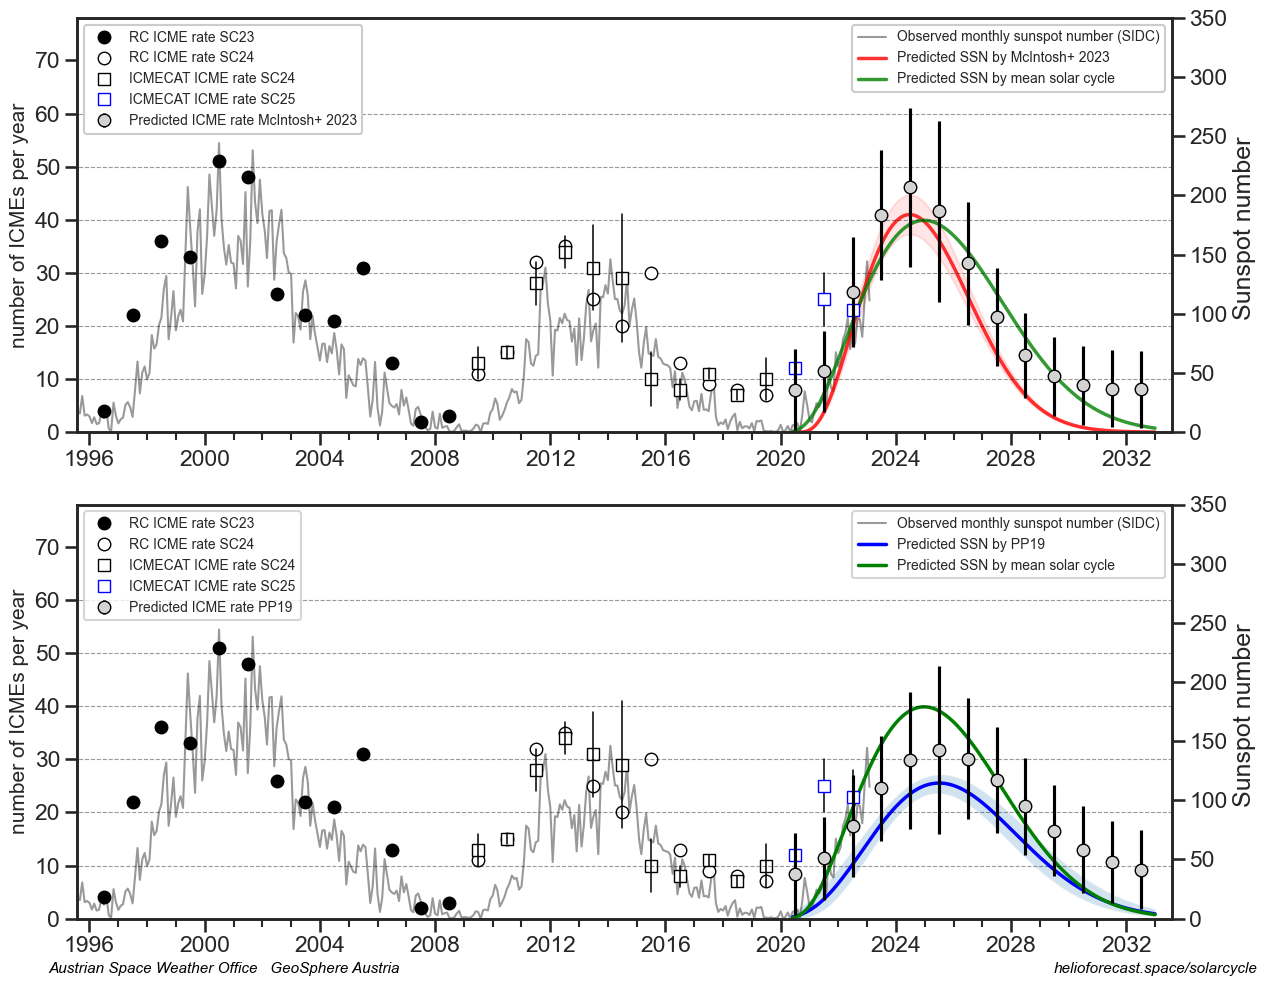

In [28]:
sns.set_context("talk")     
sns.set_style('whitegrid')
sns.set_style("ticks",{'grid.linestyle': '--'})

fig=plt.figure(300,figsize=(13,10),dpi=100)

fsize=15
max_spot=350
max_icme=80

################################################## MC23 model


ax1 = plt.subplot(211) 


################## SSN
ax2=ax1.twinx()

#grid on both panels
gridtime=[datetime.datetime(1995, 1,1), datetime.datetime(2035, 1, 1)]

for i in np.arange(0,70,10):
    ax1.plot(gridtime,[0,0]+i,linestyle='--',color='k',alpha=0.4,lw=0.8)


ax2.plot(ssn_m.time[:-6],ssn_m.spot[:-6],'-k',alpha=0.4,linewidth=1.5,label='Observed monthly sunspot number (SIDC)')
ax2.plot(times_25_daily,spots_predict_25_daily_mc3,'-r',alpha=0.8,linewidth=2.5,label='Predicted SSN by McIntosh+ 2023')
ax2.plot(times_25_daily,spots_predict_25m_daily,'-g',alpha=0.8,linewidth=2.5,label='Predicted SSN by mean solar cycle')
ax2.fill_between(times_25_daily, spots_predict_25_daily_lower68_mc3, spots_predict_25_daily_upper68_mc3, alpha=0.1, color='red')


ax2.set_ylabel('Sunspot number ')
ax2.set_xlim(datetime.datetime(1995,8,1),datetime.datetime(2033,8,1))
ax2.set_ylim(0,max_spot)
years = mdates.YearLocator()   # every year
ax2.xaxis.set_minor_locator(years)
legend1=ax2.legend(loc=1,fontsize=10)
legend1.get_frame().set_alpha(None)

########

ax1.plot(yearly_mid_times_23,rc_rate23, color='black',marker='o',markerfacecolor='black',label='RC ICME rate SC23',linestyle='')
ax1.plot(yearly_mid_times_24,rc_rate24, color='black', marker='o',markerfacecolor='white',label='RC ICME rate SC24',linestyle='')
ax1.plot(yearly_mid_times_24,ic_rate24, color='black', marker='s',markerfacecolor='white',label='ICMECAT ICME rate SC24',linestyle='')
ax1.plot([icrate.year[2:],icrate.year[2:]],[icrate.mean1[2:]-icrate.std1[2:],icrate.mean1[2:]+icrate.std1[2:]],'-k',lw=1.1,label='')

ax1.plot(yearly_mid_times_25[0:3],ic_rate25, color='blue', marker='s',markerfacecolor='white',label='ICMECAT ICME rate SC25',linestyle='')
ax1.errorbar(yearly_mid_times_25,icmes_predict_25_mc23,yerr=ic_rate_25_mc23_std, color='black', marker='o',markerfacecolor='lightgrey',label='Predicted ICME rate McIntosh+ 2023',linestyle='')
ax1.set_ylabel('number of ICMEs per year',fontsize=fsize)
legend2=ax1.legend(loc=2,fontsize=10)
legend2.get_frame().set_alpha(None)

ax1.set_zorder(3) 
ax2.set_zorder(1) 
ax1.patch.set_visible(False)


    
ax1.set_ylim(0,78)




############################################################## PP19 panel
ax3 = plt.subplot(212) 

##########ICR axis
ax3.plot(yearly_mid_times_23,rc_rate23, color='black',marker='o',markerfacecolor='black',label='RC ICME rate SC23',linestyle='')
ax3.plot(yearly_mid_times_24,rc_rate24, color='black', marker='o',markerfacecolor='white',label='RC ICME rate SC24',linestyle='')
ax3.plot(yearly_mid_times_24,ic_rate24, color='black', marker='s',markerfacecolor='white',label='ICMECAT ICME rate SC24',linestyle='')
ax3.plot([icrate.year[2:],icrate.year[2:]],[icrate.mean1[2:]-icrate.std1[2:],icrate.mean1[2:]+icrate.std1[2:]],'-k',lw=1.1,label='')
ax3.plot(yearly_mid_times_25[0:3],ic_rate25, color='blue', marker='s',markerfacecolor='white',label='ICMECAT ICME rate SC25',linestyle='')
ax3.errorbar(yearly_mid_times_25,icmes_predict_25pp,yerr=ic_rate_25_pp_std, color='black', marker='o',markerfacecolor='lightgrey',label='Predicted ICME rate PP19',linestyle='', zorder=3)

ax3.set_ylabel('number of ICMEs per year',fontsize=fsize)
ax3.legend(loc=2,fontsize=10)

######SSN axis
ax4=ax3.twinx()
#observed SSN
ax4.plot(ssn_m.time[:-6],ssn_m.spot[:-6],'-k',alpha=0.4,linewidth=1.5,label='Observed monthly sunspot number (SIDC)')
#PP25 prediction
ax4.plot(times_25_daily,spots_predict_25pp_daily,'-b',alpha=1,linewidth=2.5,label='Predicted SSN by PP19')
ax4.fill_between(times_25_daily,spots_predict_25pp_daily_low,spots_predict_25pp_daily_high,alpha=0.2)
#mean cycle
ax4.plot(times_25_daily,spots_predict_25m_daily,'-g',alpha=1,linewidth=2.5,label='Predicted SSN by mean solar cycle')
ax4.set_ylabel('Sunspot number ')
ax4.set_xlim(datetime.datetime(1995,8,1),datetime.datetime(2033,8,1))
ax4.set_ylim(0,max_spot)
years = mdates.YearLocator()   # every year
ax4.xaxis.set_minor_locator(years)
ax4.legend(loc=1,fontsize=10)

ax3.set_ylim(0,78)
for i in np.arange(0,70,10):
    ax3.plot(gridtime,[0,0]+i,linestyle='--',color='k',alpha=0.4,lw=0.8)
    
    
ax3.set_zorder(3) 
ax4.set_zorder(1) 
ax3.patch.set_visible(False)

    
plt.figtext(0.05,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.98,0.01,'helioforecast.space/solarcycle', color='black', ha='right',fontsize=fsize-4, style='italic')

plt.tight_layout()

#plt.annotate('(a)',[0.0,0.965],xycoords='figure fraction',weight='bold')
#plt.annotate('(b)',[0.0,0.47],xycoords='figure fraction',weight='bold')

#plt.savefig('results/plots_rate/fig3_sc25_predictions.pdf', dpi=100)
plt.savefig(outputdirectory+'/cycle25_icme_rate_predictions.png', dpi=100)
plt.savefig(outputdirectory+'/cycle25_icme_rate_predictions.pdf', dpi=100)

## solar cycle progression

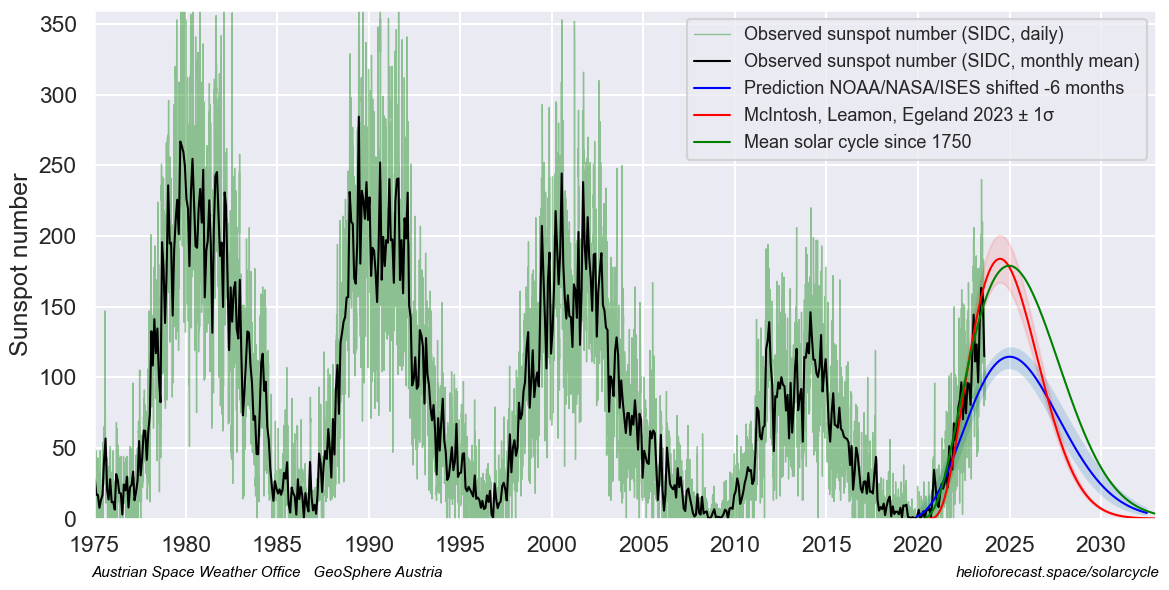

In [21]:

sns.set_context('talk')
sns.set_style('darkgrid')
fig=plt.figure(30,figsize=(12,6),dpi=100)

#print('get sunspot number from SIDC')    
#get 13month smoothed sunspot number from SIDC
#http://www.sidc.be/silso/datafiles
#add year;month;year2;spot;stand;obs;check in first row to read pandas dataframe


file='ssn_m.p'  
ssn_m=pickle.load(open(data_path+file, "rb"))

fsize=15


ax1 = plt.subplot(111) 
ax1.plot(ssn.time,ssn.spot,'-g',alpha=0.4,linewidth=1.0,label='Observed sunspot number (SIDC, daily)')
#ax1.plot(ssn.time,ssn.spot_mean_13,'-k',alpha=0.5,linewidth=1.5,label='Observed sunspot number (SIDC, 13 month smoothed)')
ax1.plot(ssn_m.time+15,ssn_m.spot,'-k',alpha=1,linewidth=1.5,label='Observed sunspot number (SIDC, monthly mean)')



#make pp19 begin time earlier
import copy
times_25_daily_shift=copy.deepcopy(times_25_daily)

for i in np.arange(len(times_25_daily_shift)):
    times_25_daily_shift[i]=times_25_daily_shift[i]-timedelta(days=6*30)

#PP19 prediction
ax1.plot(times_25_daily_shift,spots_predict_25pp_daily,'-b',alpha=1,linewidth=1.5,label='Prediction NOAA/NASA/ISES shifted -6 months')
ax1.fill_between(times_25_daily_shift,spots_predict_25pp_daily_low,spots_predict_25pp_daily_high,alpha=0.2)

#MC20 prediction
#ax1.plot(times_25_daily,spots_predict_25_daily,'--r',alpha=0.5,linewidth=1.0,label='McIntosh et al. (2020)')
#ax1.fill_between(times_25_daily, spots_predict_25_daily_lower68, spots_predict_25_daily_upper68, alpha=0.2)

#MC22 prediction
#ax1.plot(times_25_daily,spots_predict_25_daily_mc2,'-r',alpha=1,linewidth=1.5,label='McIntosh+ 2023 ')
#ax1.fill_between(times_25_daily, spots_predict_25_daily_lower68_mc2, spots_predict_25_daily_upper68_mc2, alpha=0.1, color='red')



#MC23 prediction
ax1.plot(times_25_daily,spots_predict_25_daily_mc3,'-r',alpha=1,linewidth=1.5,label='McIntosh, Leamon, Egeland 2023 ± 1σ ')
ax1.fill_between(times_25_daily, spots_predict_25_daily_lower68_mc3, spots_predict_25_daily_upper68_mc3, alpha=0.1, color='red')



#mean cycle
ax1.plot(times_25_daily,spots_predict_25m_daily,'-g',alpha=1,linewidth=1.5,label='Mean solar cycle since 1750')
ax1.set_xlim(datetime.datetime(1749,1,1),datetime.datetime(2035,1,1))


#ax1.plot(times_25_daily,spots_predict_25_daily,'-k',alpha=1,linewidth=1.5,label='Solar dynamo revolution April 2021')
#ax1.fill_between(times_25_daily, spots_predict_25_daily_lower68, spots_predict_25_daily_upper68, alpha=0.2)

ax1.set_ylim(0,360)
ax1.set_ylabel('Sunspot number')

plt.figtext(0.09,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.98,0.01,'helioforecast.space/solarcycle', color='black', ha='right',fontsize=fsize-4, style='italic')


plt.legend(loc='upper right',fontsize=8)
plt.tight_layout()

plt.savefig(outputdirectory+'/cycle25_prediction.png',dpi=100)

#with shorter interval

plt.legend(loc='upper right',fontsize=13)
ax1.set_xlim(datetime.datetime(1975,1,1),datetime.datetime(2033,1,1))

years = mdates.YearLocator(5)   # every year
ax1.xaxis.set_major_locator(years)
myformat = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(myformat)
plt.savefig(outputdirectory+'/cycle25_prediction_short.png',dpi=100)
plt.savefig(outputdirectory+'/cycle25_prediction_short.pdf')

last update: 2023-09-06


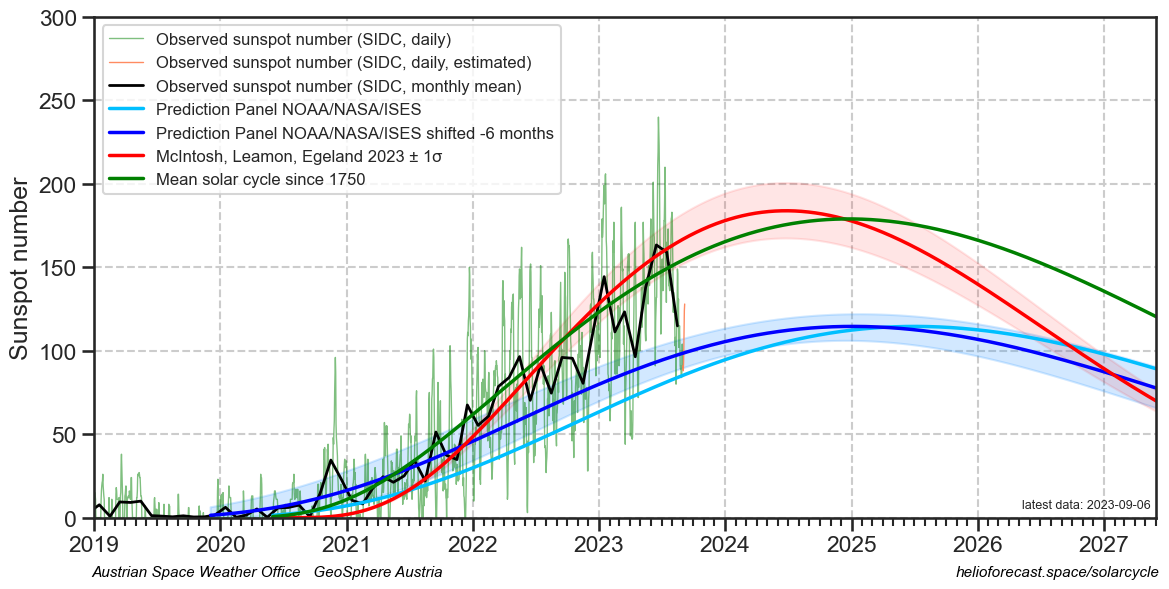

In [22]:
#with shortest interval

#Extra plot for solar cycle comparison
sns.set_context('talk')
sns.set_style('ticks')
fig=plt.figure(4,figsize=(12,6),dpi=100)

#print('get sunspot number from SIDC')    
#get 13month smoothed sunspot number from SIDC
#http://www.sidc.be/silso/datafiles
#add year;month;year2;spot;stand;obs;check in first row to read pandas dataframe


file='ssn_m.p'  
ssn_m=pickle.load(open(data_path+file, "rb"))

file='ssn_prelim.p'
ssn_p=pickle.load(open(data_path+file, "rb"))

fsize=15
max_spot=420

ax1 = plt.subplot(111) 
ax1.plot(ssn.time,ssn.spot,'-g',alpha=0.5,linewidth=1.0,label='Observed sunspot number (SIDC, daily)')
ax1.plot(ssn_p.time,ssn_p.spot,color='coral',alpha=0.9,linewidth=1.0,label='Observed sunspot number (SIDC, daily, estimated)')
#ax1.plot(ssn.time,ssn.spot_mean_13,'-k',alpha=0.5,linewidth=1.5,label='Observed sunspot number (SIDC, 13 month smoothed)')

#move average to monthly midpoint
ax1.plot(ssn_m.time+15,ssn_m.spot,'-k',alpha=1,linewidth=2,label='Observed sunspot number (SIDC, monthly mean)')

    
#PP19 prediction
ax1.plot(times_25_daily,spots_predict_25pp_daily,color='deepskyblue',alpha=1,linewidth=2.5,label='Prediction Panel NOAA/NASA/ISES')
#ax1.fill_between(times_25_daily,spots_predict_25pp_daily_low,spots_predict_25pp_daily_high,alpha=0.2)

ax1.plot(times_25_daily_shift,spots_predict_25pp_daily,color='blue',alpha=1,linewidth=2.5,label='Prediction Panel NOAA/NASA/ISES shifted -6 months')
ax1.fill_between(times_25_daily_shift,spots_predict_25pp_daily_low,spots_predict_25pp_daily_high,alpha=0.2, color='dodgerblue')



#MC20
#ax1.plot(times_25_daily,spots_predict_25_daily,'--r',alpha=0.5,linewidth=2.5,label='McIntosh et al. (2020)')
#ax1.fill_between(times_25_daily, spots_predict_25_daily_lower68, spots_predict_25_daily_upper68, alpha=0.1, color='red')


#MC23

#ax1.plot(times_25_daily,spots_predict_25_daily_mc2,'-r',alpha=1,linewidth=2.5,label='McIntosh+ 2023 / Terminator 12/2021')
#ax1.fill_between(times_25_daily, spots_predict_25_daily_lower68_mc2, spots_predict_25_daily_upper68_mc3, alpha=0.1, color='red')


#MC23


ax1.plot(times_25_daily,spots_predict_25_daily_mc3,'-r',alpha=1,linewidth=2.5,label='McIntosh, Leamon, Egeland 2023 ± 1σ')
ax1.fill_between(times_25_daily, spots_predict_25_daily_lower68_mc3, spots_predict_25_daily_upper68_mc3, alpha=0.1, color='red')




#mean cycle
ax1.plot(times_25_daily,spots_predict_25m_daily,'-g',alpha=1,linewidth=2.5,label='Mean solar cycle since 1750')
ax1.set_xlim(datetime.datetime(1749,1,1),datetime.datetime(2035,1,1))
ax1.set_ylim(0,max_spot)
ax1.set_ylabel('Sunspot number')


plt.legend(loc='upper left',fontsize=12)
print('last update: '+str(mdates.num2date(ssn_p.time.tail(1))[0])[0:10])
plt.annotate('latest data: '+str(mdates.num2date(ssn_p.time.tail(1))[0])[0:10],xy=(0.995,0.02),xycoords='axes fraction',fontsize=9,ha='right')

plt.figtext(0.09,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.98,0.01,'helioforecast.space/solarcycle', color='black', ha='right',fontsize=fsize-4, style='italic')

ax1.set_xlim(datetime.datetime(2019,1,1),datetime.datetime(2027,6,1))
ax1.set_ylim(0,300)
months = mdates.MonthLocator()   # every year
ax1.xaxis.set_minor_locator(months)
ax1.grid(linestyle='--')
plt.tight_layout()
plt.savefig(outputdirectory+'/cycle25_prediction_focus.png',dpi=100)

# 4 Parker Probe ICME rate prediction

### make PSP and Solar Orbiter position

In [23]:
frame='HEEQ'
starttime =datetime.datetime(2018, 8,13)
endtime = datetime.datetime(2025, 8, 31)
pspt_time = []
res_in_days=1
while starttime < endtime:
    pspt_time.append(starttime)
    starttime += timedelta(days=res_in_days)
pspt_time_num=parse_time(pspt_time).plot_date
starttime =datetime.datetime(2018, 8,13)

spice.furnish(spicedata.get_kernel('psp_pred'))
pspt=spice.Trajectory('SPP')
pspt.generate_positions(pspt_time,'Sun',frame)
psp_speed=pspt.speed.value
pspt.change_units(astropy.units.AU)  
[psp_r, psp_lat, psp_lon]=hd.cart2sphere(pspt.x,pspt.y,pspt.z)
print('PSP pos')
print()

frame='HEEQ'
starttime =datetime.datetime(2020, 3,1)
endtime = datetime.datetime(2030, 9, 1)
solot_time = []
res_in_days=1
while starttime < endtime:
    solot_time.append(starttime)
    starttime += timedelta(days=res_in_days)
solot_time_num=parse_time(solot_time).plot_date     
starttime =datetime.datetime(2020, 3,1)

spice.furnish(spicedata.get_kernel('solo_2020'))
solot=spice.Trajectory('Solar Orbiter')
solot.generate_positions(solot_time,'Sun',frame)
solot.change_units(astropy.units.AU)  
[solo_r, solo_lat, solo_lon]=hd.cart2sphere(solot.x,solot.y,solot.z)
print('Solo pos')





############################################## BepiColombo

starttime =datetime.datetime(2018, 10, 21)
endtime = datetime.datetime(2025, 11, 2)
bepi_time = []
while starttime < endtime:
    bepi_time.append(starttime)
    starttime += timedelta(days=res_in_days)

spice.furnish(spicedata.get_kernel('bepi_pred'))
bepi=spice.Trajectory('BEPICOLOMBO MPO') # or BEPICOLOMBO MMO
bepi.generate_positions(bepi_time,'Sun',frame)
bepi.change_units(astropy.units.AU)  
[bepi_r, bepi_lat, bepi_lon]=hd.cart2sphere(bepi.x,bepi.y,bepi.z)

print('Bepi done')


#add mercury
planet_kernel=spicedata.get_kernel('planet_trajectories')
starttime= datetime.datetime(2025, 11, 3)
endtime = datetime.datetime(2032, 12, 31)
mercury_time = []
while starttime < endtime:
    mercury_time.append(starttime)
    starttime += timedelta(days=res_in_days)



sta_time=solot_time
spice.furnish(spicedata.get_kernel('stereo_a_pred'))
sta=spice.Trajectory('-234')  
sta.generate_positions(solot_time,'Sun',frame)  
sta.change_units(astropy.units.AU)  
[sta_r, sta_lat, sta_lon]=hd.cart2sphere(sta.x,sta.y,sta.z)    
    
    
mercury=spice.Trajectory('1')  #barycenter
mercury.generate_positions(mercury_time,'Sun',frame)  
mercury.change_units(astropy.units.AU)  
[mercury_r, mercury_lat, mercury_lon]=hd.cart2sphere(mercury.x,mercury.y,mercury.z)
print('mercury') 

#combine bepi trajectory with Mercury
bepi_time2=np.hstack([bepi_time,mercury_time])
bepi_r2=np.hstack([bepi_r,mercury_r])
bepi_lon2=np.hstack([bepi_lon,mercury_lon])
bepi_lat2=np.hstack([bepi_lat,mercury_lat])


#sns.set_style('darkgrid')
#plt.figure(21,dpi=70)
#sns.histplot(psp_r)
#sns.histplot(solo_r)
#sns.histplot(bepi_r)
#sns.histplot(sta_r)
#plt.ylim(0,5)
#plt.xlabel('AU')

PSP pos



/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1340 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1340 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Solo pos
Bepi done
mercury


/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 2192 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [24]:
#get the speed in hourly resolution

frame='HEEQ'
starttime =datetime.datetime(2018, 8,13)
endtime = datetime.datetime(2025, 8, 31)
pspt_time_highres = []
res_in_days=1/24.
while starttime < endtime:
    pspt_time_highres.append(starttime)
    starttime += timedelta(days=res_in_days)
pspt_time_highres_num=parse_time(pspt_time_highres).plot_date+ mdates.date2num(np.datetime64('0000-12-31'))
starttime =datetime.datetime(2018, 8,13)

pspt_highres=spice.Trajectory('SPP')
pspt_highres.generate_positions(pspt_time_highres,'Sun',frame)
psp_highres_speed=pspt_highres.speed.value
pspt_highres.change_units(astropy.units.AU)  
[psp_highres_r, psp_highres_lat, psp_highres_lon]=hd.cart2sphere(pspt_highres.x,pspt_highres.y,pspt_highres.z)

#plt.figure(22,dpi=70)
#plt.title('PSP speed histogram full nominal mission')
#plt.plot(psp_highres_r,psp_highres_speed,'.k')
#plt.xlabel('AU')

print('psp maximum speed ',np.max(psp_highres_speed),' km/s at ',psp_highres_r[np.argmax(psp_highres_speed)], ' AU')

psp maximum speed  189.40565042481333  km/s at  0.04589802143421681  AU


### Make trajectory plots 

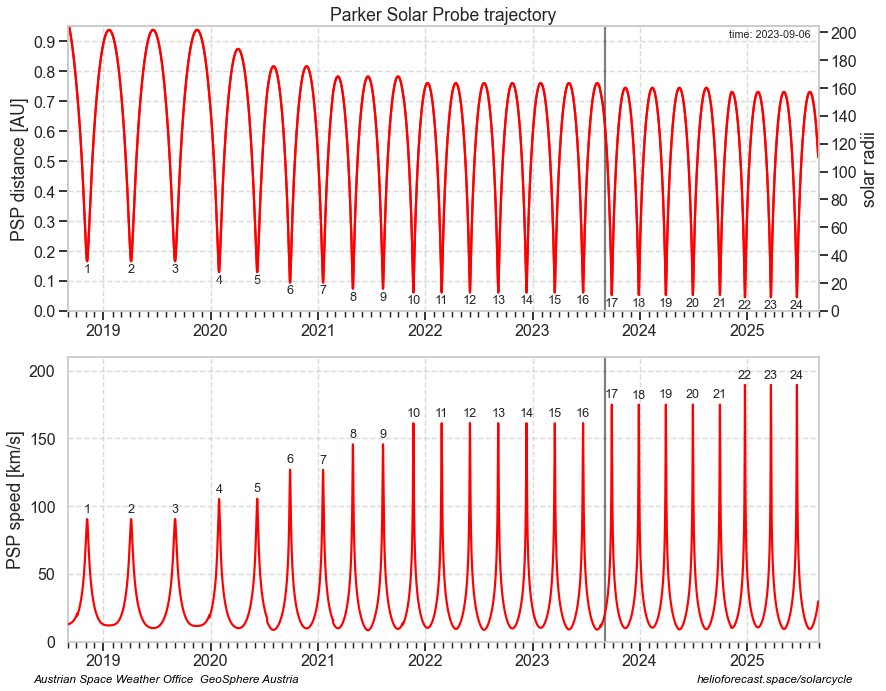

In [25]:
#%matplotlib inline
sns.set_context('talk')
sns.set_style('whitegrid')

fig=plt.figure(23,figsize=(13,10),dpi=70)


psp_plot_time=pspt_time_highres_num-mdates.date2num(np.datetime64('0000-12-31'))

ax1 = plt.subplot(211) 
ax1.plot_date(psp_plot_time,psp_highres_r,c='r',linestyle='-',markersize=0)

ax1.set_ylim(0,0.95)
ax1.set_xlim(datetime.datetime(2018,9,1),datetime.datetime(2025,9,1))
ax1.yaxis.set_ticks(np.arange(0,1,0.1))
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
ax1.tick_params(which="both", bottom=True)
plt.ylabel('PSP distance [AU]')
ax1.grid(which='major',linestyle='--',alpha=0.7)
#ax1.set_zorder(3)

plt.title('Parker Solar Probe trajectory')

#grid
#gridtime=[datetime.datetime(2018, 1,1), datetime.datetime(2026, 1, 1)]
#for i in np.arange(0,1,0.1):
#    ax1.plot(gridtime,[0,0]+i,linestyle='--',color='grey',alpha=0.7,lw=0.8)


    
ax2=ax1.twinx()
ax2.plot_date(psp_plot_time,215.03*psp_highres_r,c='r',linestyle='-',markersize=0)
ax2.set_ylabel('solar radii')
ax2.set_ylim(0,0.95*215.03)
ax2.set_xlim(datetime.datetime(2018,9,1),datetime.datetime(2025,9,1))
ax2.yaxis.set_ticks(np.arange(0,220,20))
ax2.grid(visible=None)


plt.annotate('time: '+str(datetime.datetime.now())[0:10],xy=(0.99,0.96),xycoords='axes fraction',fontsize=11,ha='right')


sns.set_style('whitegrid')
ax3 = plt.subplot(212) 
ax3.plot_date(psp_plot_time,psp_highres_speed,'-r',zorder=3)
plt.ylabel('PSP speed [km/s]')
#plt.xlabel('year')
ax3.set_xlim(datetime.datetime(2018,9,1),datetime.datetime(2025,9,1))
ax3.set_ylim(0,210)
ax3.xaxis.set_minor_locator(mdates.MonthLocator())
ax3.tick_params(which="both", bottom=True)
ax3.grid(which='major',linestyle='--',alpha=0.7)

#current time
current_mdates = mdates.date2num(datetime.datetime.now())

ax1.plot([current_mdates,current_mdates],[-50,50],linestyle='-', color='black',alpha=0.5)
ax3.plot([current_mdates,current_mdates],[0,300],linestyle='-', color='black',alpha=0.5)



#find perihelia and aphelia
dr=np.gradient(psp_highres_r)
dr_minmax=np.where(np.diff(np.sign(dr)))[0]
for i in np.arange(0,48,2):
    ax1.text(psp_plot_time[dr_minmax[i]],psp_highres_r[dr_minmax[i]]-0.038,str(int(i/2)+1),fontsize=13,zorder=0,horizontalalignment='center')



#find perihelia and aphelia
for i in np.arange(0,48,2):
    ax3.text(psp_plot_time[dr_minmax[i]],psp_highres_speed[dr_minmax[i]]+5,str(int(i/2)+1),fontsize=13,horizontalalignment='center')

plt.tight_layout()
plt.figtext(0.95,0.008,'helioforecast.space/solarcycle', fontsize=12, ha='right',color='k',style='italic')     
plt.figtext(0.05,0.008,'Austrian Space Weather Office  GeoSphere Austria', fontsize=12, ha='left',color='k',style='italic')     


plt.savefig(outputdirectory+'/psp_orbits.png', dpi=100)

/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1096 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1096 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


solo maximum speed  60.739231557446864  km/s at  0.2842351199095981  AU


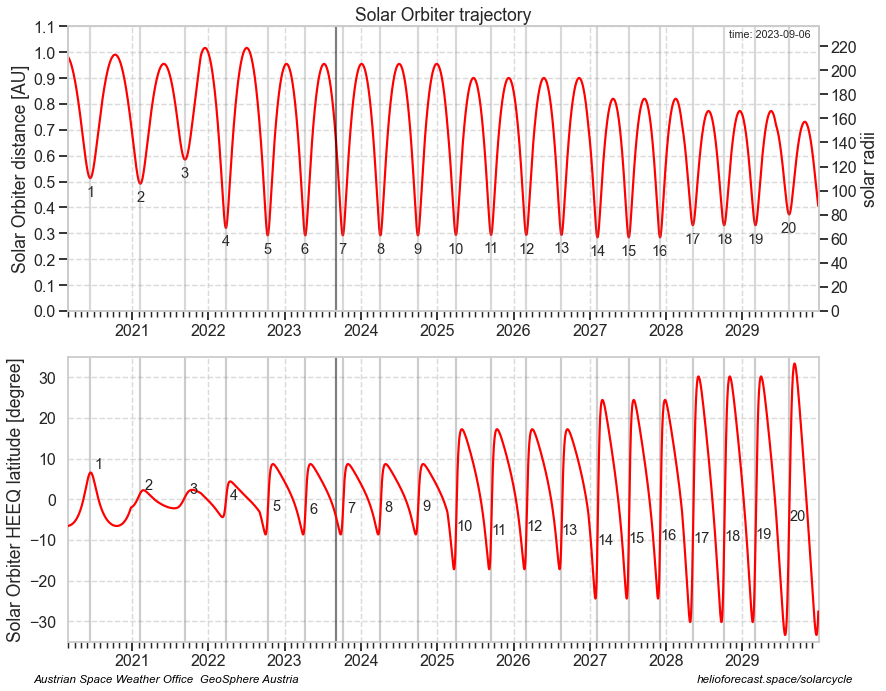

In [26]:
#same thing for Solar Orbiter


frame='HEEQ'
starttime =datetime.datetime(2020, 3,1)
endtime = datetime.datetime(2029, 12, 31)
solo_time_highres = []
res_in_days=1.
while starttime < endtime:
    solo_time_highres.append(starttime)
    starttime += timedelta(days=res_in_days)
solo_time_highres_num=parse_time(solo_time_highres).plot_date#-mdates.date2num(np.datetime64('0000-12-31'))
starttime =datetime.datetime(2020, 3,1)

solo_highres=spice.Trajectory('Solar Orbiter')
solo_highres.generate_positions(solo_time_highres,'Sun',frame)
solo_highres_speed=solo_highres.speed.value
solo_highres.change_units(astropy.units.AU)  
[solo_highres_r, solo_highres_lat, solo_highres_lon]=hd.cart2sphere(solo_highres.x,solo_highres.y,solo_highres.z)

solo_highres_lat=np.degrees(solo_highres_lat)
solo_highres_lon=np.degrees(solo_highres_lon)
print('solo maximum speed ',np.max(solo_highres_speed),' km/s at ',solo_highres_r[np.argmax(solo_highres_speed)], ' AU')


#%matplotlib inline

sns.set_context('talk')
sns.set_style('whitegrid')

fig=plt.figure(24,figsize=(13,10),dpi=70)

ax1 = plt.subplot(211) 
ax1.plot_date(solo_time_highres_num,solo_highres_r,c='r',linestyle='-',markersize=0)

ax1.set_xlim(datetime.datetime(2020,3,1),datetime.datetime(2029,12,31))

ax1.yaxis.set_ticks(np.arange(0,1.3,0.1))
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
ax1.tick_params(which="both", bottom=True)
plt.ylabel('Solar Orbiter distance [AU]')
ax1.grid(which='major',linestyle='--',alpha=0.7)
#ax1.set_zorder(3)

ax1.set_ylim(0,1.1)
plt.annotate('time: '+str(datetime.datetime.now())[0:10],xy=(0.99,0.96),xycoords='axes fraction',fontsize=11,ha='right')


plt.title('Solar Orbiter trajectory')

#grid
#gridtime=[datetime.datetime(2018, 1,1), datetime.datetime(2026, 1, 1)]
#for i in np.arange(0,1,0.1):
#    ax1.plot(gridtime,[0,0]+i,linestyle='--',color='grey',alpha=0.7,lw=0.8)

    
ax2=ax1.twinx()
ax2.plot_date(solo_time_highres_num,215.03*solo_highres_r,c='r',linestyle='',markersize=0)
ax2.set_ylabel('solar radii')
ax2.set_xlim(datetime.datetime(2020,3,1),datetime.datetime(2029,12,31))
ax2.yaxis.set_ticks(np.arange(0,260,20))
ax2.grid(visible=None)
ax2.set_ylim(0,1.1*215.03)



sns.set_style('whitegrid')
ax3 = plt.subplot(212) 
ax3.plot_date(solo_time_highres_num,solo_highres_lat,'-r',zorder=3)
plt.ylabel('Solar Orbiter HEEQ latitude [degree]')
#plt.xlabel('year')
ax3.set_xlim(datetime.datetime(2020,3,1),datetime.datetime(2029,12,31))

ax3.set_ylim(-35,35)
ax3.xaxis.set_minor_locator(mdates.MonthLocator())
ax3.tick_params(which="both", bottom=True)
ax3.grid(which='major',linestyle='--',alpha=0.7)

#find perihelia and aphelia
dr=np.gradient(solo_highres_r)
dr_minmax=np.where(np.diff(np.sign(dr)))[0]



current_mdates = mdates.date2num(datetime.datetime.now())

ax1.plot([current_mdates,current_mdates],[-50,50],linestyle='-', color='black',alpha=0.5)
ax3.plot([current_mdates,current_mdates],[-50,50],linestyle='-', color='black',alpha=0.5)

#plot numbers
for i in np.arange(0,39,2):
    ax1.text(solo_time_highres_num[dr_minmax[i]],solo_highres_r[dr_minmax[i]]-0.07,str(int(i/2)+1),fontsize=15,zorder=0,horizontalalignment='center')    
    ax1.plot([solo_time_highres_num[dr_minmax[i]],solo_time_highres_num[dr_minmax[i]]],[-50,50],linestyle='-', color='grey',alpha=0.3)

    ax3.text(solo_time_highres_num[dr_minmax[i]]+40,solo_highres_lat[dr_minmax[i]]+1,str(int(i/2)+1),fontsize=15,horizontalalignment='center')    
    ax3.plot([solo_time_highres_num[dr_minmax[i]],solo_time_highres_num[dr_minmax[i]]],[-50,50],linestyle='-', color='grey',alpha=0.4)

plt.tight_layout()
plt.figtext(0.95,0.008,'helioforecast.space/solarcycle', fontsize=12, ha='right',color='k',style='italic')     
plt.figtext(0.05,0.008,'Austrian Space Weather Office  GeoSphere Austria', fontsize=12, ha='left',color='k',style='italic')     



plt.savefig(outputdirectory+'/solo_orbits.png', dpi=100)

In [27]:
t1all = time.time()
print(' ')
print(' ')
print('---------------------------------- ')
print('icme_rate_web.py takes ', np.round((t1all-t0all)/60,2), 'minutes')
    

 
 
---------------------------------- 
icme_rate_web.py takes  1.26 minutes
